# Assignment 5


*Please fill out the relevant cells below according to the instructions. When done, save the notebook and export it to PDF, upload both the `ipynb` and the PDF file to Canvas.*

## Group Members

*Group submission is highly encouraged. If you submit as part of group, list all group members here. Groups can comprise up to 4 students.*


## Problem 1: Automatic Hubble (3pts)

Go back to Assignment 3. Get the Hubble data and take the GP error model from Problem 1.3 to solve the linear regression with correlated errors, but this time use `emcee` to get the posteriors.

Adopt non-informative priors, i.e. $p(b) \propto (1+b^2)^{-3/2}$ and $p(\sigma_y)\propto 1/\sigma_y$, and whatever you feel is appropriate for the priors of the parameter $\alpha$ and $\tau$ of the Matern kernel.

Plot the parameter contours with `corner` and make another plot that compares the data with samples of the posterior.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
file1 = open("hubble_corrected.txt","r+") 
file1_read = file1.read()
s = StringIO(file1_read)
data_table = np.genfromtxt(s, names = True, dtype=None)
V = data_table['V']
R = data_table['R']

In [6]:
from sklearn.metrics import pairwise_distances
import emcee
import corner
from scipy.stats import gamma

# Specify data for the model fitting
x = V.reshape(-1, 1)
y = R.reshape(-1, 1)

# Define log likelihood function
def error(y,b,X):
    return y-b*X

def d(X):
    return pairwise_distances(X)

def keppa(X,alpha,tau):
    return alpha**2*(1+np.sqrt(3)*d(X)/tau) * np.exp(-np.sqrt(3)*d(X)/tau)

def K_theta(sigma_y,X,alpha,tau):
    return sigma_y**2*np.identity(len(X)) + keppa(X,alpha,tau)

def log_likelihood(X, y, params):
    b,sigma_y,alpha,tau = params
    K_t = K_theta(sigma_y,X,alpha,tau)
    e = error(y,b,X)
    N = len(X)
    return -1/2*((e.T@np.linalg.inv(K_t)@e)[0][0]) - 1/2*np.log(np.linalg.det(K_t)) - N/2*np.log(2*np.pi)

# Define log prior
alpha_gamma = gamma(2,scale=1)
tau_gamma = gamma(10,scale=5)
def log_prior(params):
    b,sigma_y,alpha,tau = params
    if tau < 0 or alpha < 0 or sigma_y <=0:
        return -np.inf
    log_prior = -(3/2)*np.log(1+b**2) + np.log(1/sigma_y) + alpha_gamma.logpdf(alpha) + tau_gamma.logpdf(tau)
    return log_prior

# Define log posterior (unnormalized)
def log_probability(params, X, y):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(X, y, params)

# Initialize parameters
b_init = 0.0015
sigma_y_init = 0.1
alpha_init = 1
tau_init = 100
params_init = np.asarray([b_init,sigma_y_init,alpha_init,tau_init])

# create a small ball around the MLE the initialize each walker 
nwalkers, ndim = 30, 4
pos = params_init + 1e-4 * np.random.randn(nwalkers, ndim)

# run emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y))
sampler.run_mcmc(pos, 5000, progress=False);

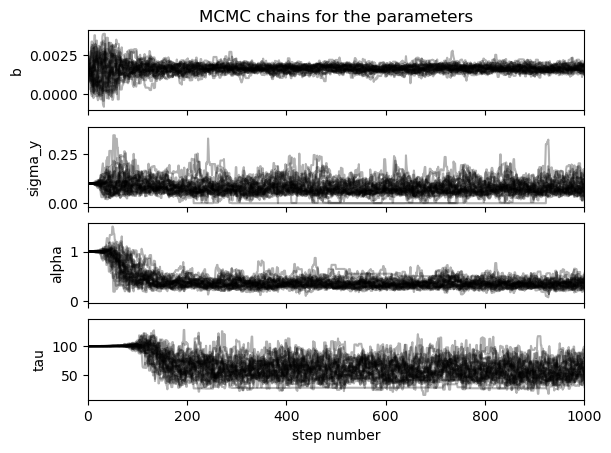

In [7]:
%matplotlib inline

fig, axes = plt.subplots(ndim, sharex=True)
samples = sampler.get_chain()
labels = ["b", "sigma_y", "alpha", "tau"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3, rasterized=True)
    ax.set_xlim(0, 1000)
    ax.set_ylabel(labels[i])

axes[-1].set_xlabel("step number");
axes[0].set_title("MCMC chains for the parameters");

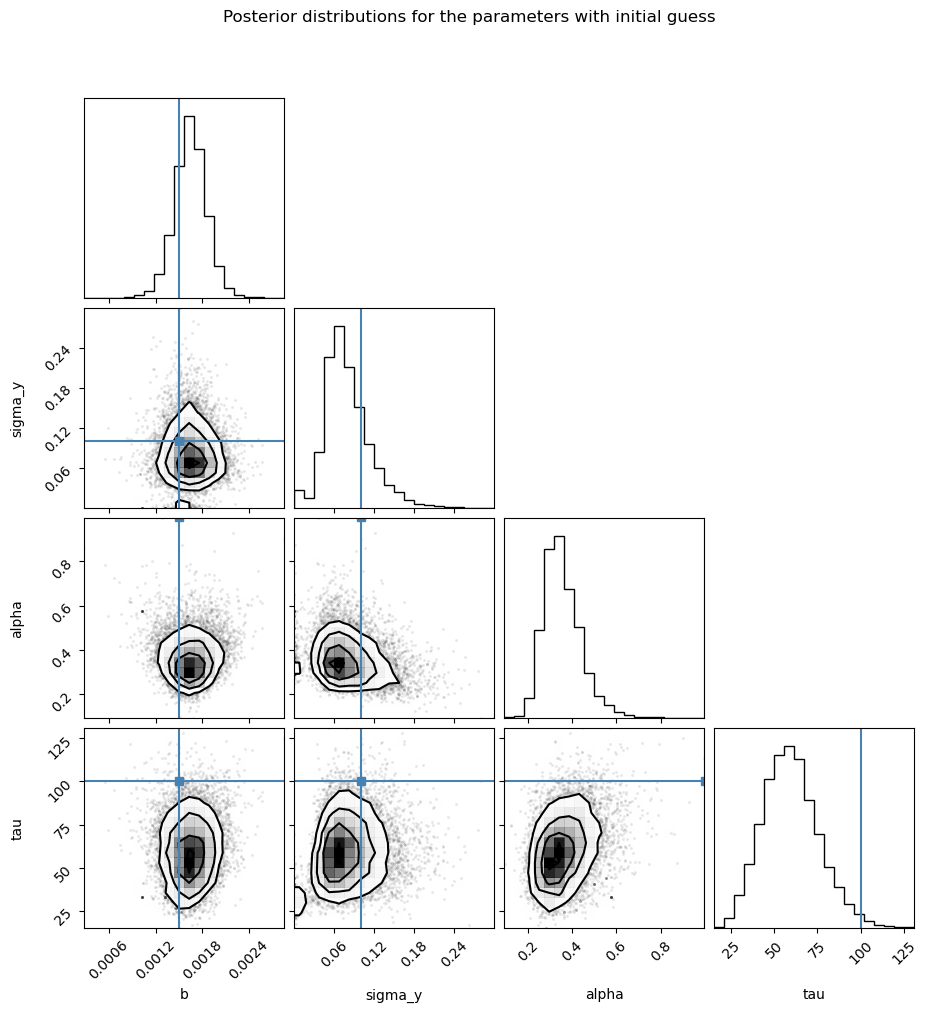

In [8]:
# Use corner to plot the posterior distributions
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
fig = corner.corner(flat_samples, labels=labels, truths=params_init);
title = fig.suptitle("Posterior distributions for the parameters with initial guess", y=1.05)

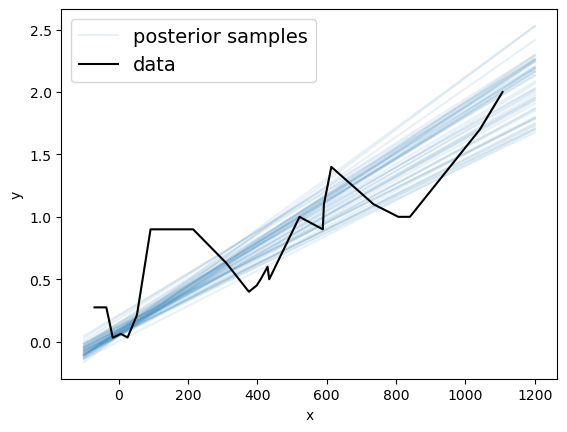

In [9]:
# Plot data and samples from the posterior ???
inds = np.random.randint(len(flat_samples), size=50)
x0 = np.linspace(-100, 1200, 100)
for i,ind in enumerate(inds):
    sample = flat_samples[ind]
    # Plot posterior samples predictions with a single legend being prediction
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[0:2]), "C0", alpha=0.1, rasterized=True, label="posterior samples" if i == 0 else None)
# Plot data
plt.plot(x, y, "k", label="data")
# Plot 
plt.legend(fontsize=14)
plt.xlabel("x")
plt.ylabel("y");


## Problem 2: HMC for Hierarchical Regression (7pts)

Implement the hierarchical linear regression model for math scores vs socio-econonic status (SES) from 100 schools we discussed in the lecture. But instead of the complicated Gibbs sampling sequence with its full conditionals, compute posteriors with HMC/NUTS.

## Problem 2.1 (3pts):

Get the data from the Hoff 2009 book [here](https://github.com/probml/pmtk3/blob/master/data/mathDataHoff.csv).
Treat each school independently and perform linear regression (with an unknown error) of math score as function of SES. Specifically, implement this model in `numpyro`:

\begin{align}
\mu &\sim \mathcal{N}(\mu_0, V_0)\\
\Sigma &\sim \mathrm{IW} (\eta_0, S_0^{-1})\\
w_j&\sim\mathcal{N}(\mu,\Sigma)\\
\sigma^2 &\sim \mathrm{IG} (\tfrac{1}{2}\nu_0, \tfrac{1}{2}\nu_0 \sigma_0^2)\\
e_{ij}&\sim\mathcal{N}(0, \sigma^2)
\end{align}

Take the mean of the posterior samples for the per-school linear regression weights and make a plot of these mean posterior predictions (see panel a) of Murphy Fig. 24.4). Store the posterior means of $w_j$ and $\sigma_j$ for every school for Problem 2.3.

**Hints**: 

* Pick reasonable values for the hyper-parameters $\mu_0, V_0,\dots$. A good method is to plot the resulting parameter distributions and compare them to the data. They should be wide enough to not overly influence the inference.
* The inverse Wishart distribution is not available in NumPyro yet. For univariate cases, it is identical to the inverse Gamma distribution. For the $2\times 2$ covariance $\Sigma$, assume independence of the slope and the intercept variances. Thus, sample two independent RVs from the inverse Gamma and treat them like a diagonal matrix covariance matrix. 
* ```
import jax.numpy as np
import numpy as onp
```

In [10]:
## Download data
import urllib.request
url = "https://raw.githubusercontent.com/probml/pmtk3/master/data/mathDataHoff.csv"
print ("download start!")
filename, headers = urllib.request.urlretrieve(url, filename="mathDataHoff.csv")
print ("download complete!")
print ("download file location: ", filename)
print ("download headers: ", headers)

## Read data
import pandas as pd
df = pd.read_csv(filename)
df.head()

## Preprocess data
# Get all the school ids
school_ids = df['sch_id'].unique()

download start!
download complete!
download file location:  mathDataHoff.csv
download headers:  Connection: close
Content-Length: 63791
Cache-Control: max-age=300
Content-Security-Policy: default-src 'none'; style-src 'unsafe-inline'; sandbox
Content-Type: text/plain; charset=utf-8
ETag: "6d38031f38a645993534540c41447f91dd9ed56dc897039f9f4ca4e9679111fa"
Strict-Transport-Security: max-age=31536000
X-Content-Type-Options: nosniff
X-Frame-Options: deny
X-XSS-Protection: 1; mode=block
X-GitHub-Request-Id: EE08:2D2E:6CCEF:A000C:643FF406
Accept-Ranges: bytes
Date: Wed, 19 Apr 2023 14:00:38 GMT
Via: 1.1 varnish
X-Served-By: cache-lga21947-LGA
X-Cache: MISS
X-Cache-Hits: 0
X-Timer: S1681912839.808592,VS0,VE116
Vary: Authorization,Accept-Encoding,Origin
Access-Control-Allow-Origin: *
X-Fastly-Request-ID: 72b7b99a24e3e451192f6441b0ae405993ccdf24
Expires: Wed, 19 Apr 2023 14:05:38 GMT
Source-Age: 0




In [11]:
import jax.numpy as np
from jax import random
import numpy as onp

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

def model(x, y=None):
    mu_0_1 = 50
    mu_0_2 = 3
    V_0 = 5
    v_0 = 1
    sigma_0 = 1

    Sigma_1 = numpyro.sample('Sigma_1', dist.InverseGamma(1,2))
    Sigma_2 = numpyro.sample('Sigma_2', dist.InverseGamma(1,2))
    sigma = numpyro.sample('sigma', 
                                  dist.InverseGamma(v_0/2, v_0*sigma_0**2/2))
    mu1 = numpyro.sample('mu1', dist.Normal(mu_0_1, V_0))
    mu2 = numpyro.sample('mu2', dist.Normal(mu_0_2, V_0))
    w1 = numpyro.sample('w1', dist.Normal(mu1, Sigma_1))
    w2 = numpyro.sample('w2', dist.Normal(mu2, Sigma_2))
   
    e = numpyro.sample('e',dist.Normal(0, sigma))

    y_ = w1 + w2*x
    # notice that we clamp the outcome of this sampling to the observation y 
    numpyro.sample('obs', dist.Normal(y_, e), obs=y)

# need to split the key for jax's random implementation
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Create space for storing the posterior means of w_j and sigma_square
w1_posterior_mean = onp.zeros(len(school_ids))
w2_posterior_mean = onp.zeros(len(school_ids))
sigma_posterior_mean = onp.zeros(len(school_ids))

# Loop throug each school and fit a model
for i,school_id in enumerate(school_ids):
    # Get the data for this school
    df_school = df[df['sch_id'] == school_id]
    print("Fitting model for school: ", school_id)
    # Get the x and y values
    x = df_school['stu_ses'].values
    y = df_school['stu_mathscore'].values
    # Fit the model
    kernel = NUTS(model, target_accept_prob=0.9)
    mcmc = MCMC(kernel, num_warmup=1000, num_samples=3000)
    mcmc.run(random.PRNGKey(0), x=x, y=y)
    mcmc.print_summary()

    # Get and store the mean of the posterior samples
    w1_posterior_mean[i] = onp.mean(mcmc.get_samples()['w1'])
    w2_posterior_mean[i] = onp.mean(mcmc.get_samples()['w2'])
    sigma_posterior_mean[i] = onp.mean(mcmc.get_samples()['sigma'])

/usr/people/yz3813/miniconda3/envs/SML505/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Fitting model for school:  1011


sample: 100%|██████████| 4000/4000 [00:10<00:00, 387.60it/s, 31 steps of size 1.17e-01. acc. prob=0.98]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      3.89      8.56      2.18      0.31      7.43   1226.97      1.00
   Sigma_2      3.68      5.46      2.11      0.33      7.52   1090.53      1.00
         e     10.70      1.47     10.55      8.49     13.10   2031.38      1.00
       mu1     51.37      2.92     51.43     46.33     55.74   1642.12      1.00
       mu2      4.06      2.94      4.23     -1.05      8.45   1378.81      1.00
     sigma     21.10     44.87     11.68      2.83     40.39   1626.45      1.00
        w1     51.76      1.91     51.77     48.53     54.85   1808.70      1.00
        w2      4.58      2.03      4.54      1.47      7.97   1737.86      1.00

Number of divergences: 0
Fitting model for school:  1031


sample: 100%|██████████| 4000/4000 [00:10<00:00, 392.36it/s, 15 steps of size 2.18e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      3.79      5.12      2.36      0.28      8.04   1198.76      1.00
   Sigma_2      3.88      5.62      2.21      0.30      8.24   1265.00      1.00
         e      7.95      1.37      7.72      5.94     10.04   1559.61      1.00
       mu1     47.41      3.01     47.04     42.89     52.61   1218.62      1.00
       mu2      5.56      3.16      5.84      0.41     10.63   1060.40      1.00
     sigma     18.56     54.64      8.66      2.35     30.44    831.88      1.00
        w1     46.32      1.65     46.27     43.45     48.87   1597.13      1.00
        w2      6.67      1.85      6.70      3.84      9.85   1721.90      1.00

Number of divergences: 5
Fitting model for school:  1033


sample: 100%|██████████| 4000/4000 [00:10<00:00, 386.35it/s, 31 steps of size 1.35e-01. acc. prob=0.97]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      3.98      7.97      2.27      0.24      8.29   1456.80      1.00
   Sigma_2      3.53      4.58      2.16      0.26      7.30   1300.91      1.00
         e      7.96      1.26      7.82      5.98      9.91   1810.12      1.00
       mu1     49.49      3.09     49.36     44.63     54.20   1330.90      1.00
       mu2      1.31      2.85      1.30     -3.28      5.97   1420.64      1.00
     sigma     17.44     52.61      8.69      1.89     29.19   1058.29      1.00
        w1     49.05      1.65     49.01     46.52     51.83   1843.48      1.00
        w2      0.74      1.59      0.72     -1.85      3.30   2072.07      1.00

Number of divergences: 0
Fitting model for school:  1301


sample: 100%|██████████| 4000/4000 [00:10<00:00, 386.86it/s, 15 steps of size 1.88e-01. acc. prob=0.89]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      4.05     11.10      2.20      0.27      7.71   1368.82      1.00
   Sigma_2      3.76      5.64      2.13      0.33      7.89    853.20      1.00
         e     10.65      1.90     10.40      7.83     13.47   1134.68      1.00
       mu1     48.32      3.26     48.12     42.97     53.41   1322.20      1.00
       mu2      3.60      3.39      3.72     -1.91      8.97   1267.59      1.00
     sigma     22.09     47.60     11.58      2.49     42.28   1226.25      1.00
        w1     47.61      2.30     47.63     43.74     51.27   1552.18      1.00
        w2      3.89      2.90      3.87     -0.72      8.55   1359.95      1.00

Number of divergences: 20
Fitting model for school:  1302


sample: 100%|██████████| 4000/4000 [00:10<00:00, 393.15it/s, 15 steps of size 1.39e-01. acc. prob=0.96]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1     10.32     15.34      6.53      0.43     20.71   1636.36      1.00
   Sigma_2      4.18      6.60      2.34      0.32      8.75   1063.35      1.00
         e      8.74      1.51      8.54      6.49     11.15   1580.88      1.00
       mu1     44.63      5.43     44.09     36.03     53.22   1334.77      1.00
       mu2      0.29      3.40      0.01     -4.91      6.06   1400.21      1.00
     sigma     17.34     43.34      9.36      2.22     30.78   1380.38      1.00
        w1     37.20      2.05     37.14     33.90     40.56   1415.45      1.00
        w2     -0.86      2.54     -0.96     -5.14      3.20   1677.86      1.00

Number of divergences: 0
Fitting model for school:  1311


sample: 100%|██████████| 4000/4000 [00:10<00:00, 374.16it/s, 15 steps of size 1.40e-01. acc. prob=0.96]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      7.73     15.56      4.40      0.30     15.53    763.20      1.00
   Sigma_2      3.95      7.12      2.24      0.31      7.71    910.59      1.00
         e      6.41      1.29      6.21      4.47      8.35   1376.05      1.00
       mu1     44.50      4.81     43.52     37.58     52.62   1341.61      1.00
       mu2      1.74      3.22      1.69     -3.42      6.86   1292.56      1.00
     sigma     16.23     96.70      7.00      1.54     26.05   1625.36      1.00
        w1     39.77      1.67     39.73     37.02     42.37   1776.43      1.00
        w2      1.21      2.25      1.19     -2.21      5.07   1792.87      1.00

Number of divergences: 1
Fitting model for school:  1312


sample: 100%|██████████| 4000/4000 [00:10<00:00, 388.41it/s, 31 steps of size 1.29e-01. acc. prob=0.97]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      5.87     10.12      3.42      0.25     12.52   1526.13      1.00
   Sigma_2      3.61      6.46      2.05      0.29      6.78    938.65      1.00
         e      5.95      1.18      5.78      4.07      7.69   1549.01      1.00
       mu1     44.78      4.31     43.86     38.11     51.43   1176.95      1.00
       mu2      2.86      2.80      2.90     -1.41      7.55   1538.07      1.00
     sigma     12.68     30.89      6.48      1.44     23.30   1382.37      1.00
        w1     41.32      1.45     41.24     39.12     43.86   2069.80      1.00
        w2      2.79      1.73      2.71      0.07      5.72   1769.28      1.00

Number of divergences: 0
Fitting model for school:  1342


sample: 100%|██████████| 4000/4000 [00:10<00:00, 387.73it/s, 31 steps of size 1.14e-01. acc. prob=0.98]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      4.38     19.05      2.23      0.26      7.90   1429.48      1.00
   Sigma_2      3.81      6.12      2.28      0.35      7.43   1177.84      1.00
         e     10.55      1.75     10.31      7.80     13.19   1691.16      1.00
       mu1     48.46      3.23     48.23     43.18     53.71   1344.76      1.00
       mu2      4.66      3.36      4.74     -1.04      9.89   1435.48      1.00
     sigma     20.40     45.62     11.13      3.03     37.87   1361.29      1.00
        w1     47.79      2.24     47.77     44.22     51.46   1683.86      1.00
        w2      5.45      2.86      5.46      0.56      9.75   1531.14      1.01

Number of divergences: 1
Fitting model for school:  1362


sample: 100%|██████████| 4000/4000 [00:10<00:00, 378.96it/s, 31 steps of size 1.09e-01. acc. prob=0.98]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      3.74      5.93      2.19      0.27      7.50   1171.77      1.00
   Sigma_2      3.59      5.08      2.07      0.29      7.60   1045.47      1.00
         e      7.72      1.21      7.56      5.89      9.57   1744.90      1.00
       mu1     48.80      3.00     48.71     43.98     53.64   1456.88      1.00
       mu2      2.28      2.82      2.12     -2.07      7.09   1341.29      1.01
     sigma     15.33     30.81      8.15      2.00     29.02   1689.35      1.00
        w1     48.29      1.80     48.24     45.34     51.16   1194.56      1.00
        w2      2.00      1.87      1.95     -0.83      5.23   1504.41      1.00

Number of divergences: 0
Fitting model for school:  1371


sample: 100%|██████████| 4000/4000 [00:10<00:00, 397.40it/s, 31 steps of size 9.36e-02. acc. prob=0.98]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      5.90     10.17      3.35      0.31     11.93   1576.86      1.00
   Sigma_2      3.72      5.54      2.17      0.29      7.76   1420.92      1.00
         e      9.31      1.76      9.09      6.57     11.80   1323.21      1.00
       mu1     45.15      4.24     44.59     38.68     52.30   1083.54      1.00
       mu2      1.58      3.29      1.43     -4.44      6.51   1433.43      1.00
     sigma     20.39     52.28      9.95      2.43     38.10    844.89      1.00
        w1     41.89      2.25     41.82     38.39     45.73   1375.03      1.00
        w2      1.02      2.82      1.05     -3.70      5.42   1343.29      1.00

Number of divergences: 0
Fitting model for school:  1621


sample: 100%|██████████| 4000/4000 [00:10<00:00, 378.62it/s, 31 steps of size 1.30e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      7.60     81.08      2.25      0.24      8.83    693.24      1.00
   Sigma_2      3.82      5.28      2.23      0.28      8.13   1023.21      1.00
         e      7.49      1.97      7.14      4.64     10.11    857.90      1.00
       mu1     50.95      3.76     50.94     45.01     57.15   1300.02      1.00
       mu2      4.64      3.42      4.81     -0.51     10.55    812.60      1.00
     sigma     14.51     28.81      7.84      1.83     25.42   1173.61      1.00
        w1     51.38      3.47     51.36     45.50     56.79    904.43      1.00
        w2      5.54      2.70      5.55      1.11      9.98   1007.34      1.00

Number of divergences: 5
Fitting model for school:  1631


sample: 100%|██████████| 4000/4000 [00:10<00:00, 386.47it/s, 31 steps of size 1.53e-01. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      3.85      9.63      2.18      0.26      7.60    895.10      1.00
   Sigma_2      3.92      5.84      2.22      0.29      8.27   1094.17      1.00
         e     11.85      1.56     11.72      9.36     14.27   1624.59      1.00
       mu1     50.44      2.97     50.42     46.01     55.43   1799.65      1.00
       mu2      4.48      2.98      4.65     -0.36      9.23   1220.15      1.00
     sigma     23.80     48.35     13.11      3.28     42.14   1150.46      1.00
        w1     50.52      1.99     50.52     47.23     53.70   1846.98      1.00
        w2      5.24      1.71      5.28      2.69      8.27   1687.15      1.00

Number of divergences: 7
Fitting model for school:  1642


sample: 100%|██████████| 4000/4000 [00:10<00:00, 392.25it/s, 31 steps of size 1.83e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      4.20     14.84      2.21      0.30      7.78    817.98      1.00
   Sigma_2      4.04      6.20      2.31      0.33      8.11    773.27      1.00
         e      9.14      1.60      8.95      6.66     11.56   1496.56      1.00
       mu1     49.79      3.18     49.74     44.74     55.03   1390.72      1.00
       mu2      0.76      3.14      0.57     -4.23      5.89    953.79      1.00
     sigma     18.57     34.87      9.95      2.16     35.65   1406.54      1.00
        w1     49.59      2.12     49.55     46.01     53.00   1366.88      1.00
        w2     -0.19      2.21     -0.18     -3.85      3.39   1288.36      1.00

Number of divergences: 5
Fitting model for school:  1651


sample: 100%|██████████| 4000/4000 [00:10<00:00, 387.35it/s, 31 steps of size 1.33e-01. acc. prob=0.96]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      5.07     10.44      2.55      0.30     10.21   1085.65      1.00
   Sigma_2      3.58      4.82      2.14      0.30      7.60   1156.08      1.00
         e      8.23      1.52      7.99      5.84     10.45   1283.56      1.00
       mu1     54.18      3.76     54.60     48.17     60.16   1174.94      1.00
       mu2      2.73      3.06      2.69     -2.65      7.39   1141.15      1.00
     sigma     15.48     29.42      8.75      1.81     27.87   1317.66      1.00
        w1     56.17      2.41     56.19     52.52     60.22   1251.58      1.00
        w2      2.71      2.25      2.63     -0.85      6.44   1267.65      1.00

Number of divergences: 0
Fitting model for school:  1661


sample: 100%|██████████| 4000/4000 [00:10<00:00, 372.94it/s, 31 steps of size 8.91e-02. acc. prob=0.99]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      4.16      7.28      2.23      0.30      8.46   1194.67      1.00
   Sigma_2      4.05      7.55      2.29      0.23      8.16   1209.29      1.00
         e      6.06      1.51      5.83      3.84      8.20    943.67      1.00
       mu1     52.42      3.13     52.56     47.16     57.23   1290.88      1.00
       mu2      6.03      3.18      6.28      0.77     11.00    977.21      1.00
     sigma     13.37     41.41      6.53      1.32     23.09    944.05      1.00
        w1     53.25      1.87     53.26     50.20     56.34   1058.30      1.00
        w2      7.16      1.98      7.16      4.04     10.58   1173.08      1.00

Number of divergences: 0
Fitting model for school:  1662


sample: 100%|██████████| 4000/4000 [00:10<00:00, 389.38it/s, 15 steps of size 1.61e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      5.82     45.35      2.27      0.26      8.51    764.99      1.00
   Sigma_2      3.61      5.66      2.12      0.26      7.39    974.48      1.00
         e      7.93      1.28      7.77      6.00      9.86   1131.18      1.00
       mu1     53.08      3.41     53.33     47.77     58.71   1176.74      1.00
       mu2      1.44      3.02      1.30     -3.52      6.27   1040.56      1.00
     sigma     14.90     37.41      8.35      2.26     27.17   1051.47      1.00
        w1     54.35      2.48     54.41     50.30     58.32   1089.35      1.00
        w2      0.83      2.06      0.77     -2.66      3.98    993.66      1.00

Number of divergences: 5
Fitting model for school:  1891


sample: 100%|██████████| 4000/4000 [00:10<00:00, 397.34it/s, 19 steps of size 1.21e-01. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      8.59     23.07      4.42      0.24     17.79   1582.60      1.00
   Sigma_2      4.22      6.00      2.37      0.31      9.17    893.93      1.00
         e      7.42      2.95      6.70      3.68     11.70    637.08      1.00
       mu1     44.65      4.86     44.18     36.92     52.39   1231.41      1.00
       mu2      0.14      3.51     -0.15     -5.64      5.81   1215.36      1.00
     sigma     16.33     50.09      7.82      1.41     30.26   1389.98      1.00
        w1     39.51      3.23     39.16     34.33     44.63    927.98      1.00
        w2     -1.09      2.90     -1.22     -5.47      4.03   1045.02      1.00

Number of divergences: 4
Fitting model for school:  1892


sample: 100%|██████████| 4000/4000 [00:10<00:00, 377.45it/s, 31 steps of size 1.54e-01. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      4.71     21.29      2.20      0.26      8.06   1061.76      1.00
   Sigma_2      3.97      5.84      2.25      0.27      8.70   1069.76      1.00
         e      7.73      1.68      7.47      5.21     10.06    943.59      1.00
       mu1     49.26      3.19     49.10     43.97     54.11   1046.57      1.00
       mu2      5.19      3.27      5.32     -0.30     10.32   1010.69      1.00
     sigma     15.24     28.43      8.16      1.78     27.64   1262.26      1.00
        w1     48.82      2.10     48.78     45.63     52.49   1276.39      1.00
        w2      6.19      2.44      6.16      2.20     10.20   1224.25      1.00

Number of divergences: 3
Fitting model for school:  1901


sample: 100%|██████████| 4000/4000 [00:10<00:00, 388.06it/s, 19 steps of size 1.34e-01. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      4.93     10.21      2.63      0.20     10.24   1414.31      1.00
   Sigma_2      3.84      6.41      2.19      0.29      7.70   1018.87      1.00
         e     10.36      2.54      9.90      6.74     14.08   1217.42      1.00
       mu1     46.51      3.82     46.23     40.67     52.94   1073.08      1.00
       mu2      2.57      3.35      2.53     -2.93      8.11   1602.90      1.00
     sigma     20.74     53.36     10.92      2.34     40.33   1599.18      1.00
        w1     44.46      2.86     44.38     39.95     49.15   1711.56      1.00
        w2      2.49      2.89      2.47     -2.09      7.34   1681.13      1.00

Number of divergences: 6
Fitting model for school:  1902


sample: 100%|██████████| 4000/4000 [00:10<00:00, 391.47it/s, 17 steps of size 1.50e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      5.11     26.82      2.40      0.28      8.56    720.23      1.00
   Sigma_2      4.77      6.31      2.70      0.30     10.87    895.44      1.00
         e      8.84      1.47      8.65      6.42     11.01   1384.01      1.00
       mu1     47.58      3.29     47.23     42.19     52.79   1440.76      1.00
       mu2     -0.66      3.74     -0.81     -6.70      5.30    865.32      1.00
     sigma     18.99     54.57      9.56      2.49     34.51   1220.04      1.00
        w1     46.40      1.92     46.39     43.29     49.58   1778.34      1.00
        w2     -2.84      3.13     -2.86     -8.20      2.05   1391.53      1.00

Number of divergences: 11
Fitting model for school:  1911


sample: 100%|██████████| 4000/4000 [00:10<00:00, 382.65it/s, 15 steps of size 1.60e-01. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      4.06     13.61      2.10      0.34      7.27   1102.17      1.00
   Sigma_2      3.48      4.62      2.15      0.29      7.09   1225.68      1.00
         e      8.21      1.63      8.00      5.62     10.48   1456.23      1.00
       mu1     49.81      3.18     49.71     44.75     54.85   1252.93      1.00
       mu2      2.27      2.94      2.28     -2.50      6.98   1183.97      1.00
     sigma     17.07     37.28      8.74      1.96     30.52   1017.63      1.00
        w1     49.65      2.25     49.61     46.24     53.61   1049.64      1.00
        w2      2.06      2.20      2.02     -1.56      5.53   1380.51      1.00

Number of divergences: 2
Fitting model for school:  1912


sample: 100%|██████████| 4000/4000 [00:10<00:00, 364.06it/s, 15 steps of size 2.12e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      3.80      5.53      2.21      0.33      7.78    960.81      1.00
   Sigma_2      3.65      5.55      2.12      0.35      7.27    863.18      1.00
         e      9.17      1.42      9.00      6.92     11.31   1445.11      1.00
       mu1     48.05      3.23     47.78     43.00     53.20   1429.73      1.00
       mu2      4.01      2.90      4.12     -0.36      9.08   1405.61      1.00
     sigma     20.40     43.84     10.00      1.99     39.00   1134.83      1.00
        w1     47.18      1.87     47.13     43.83     49.93   1618.63      1.00
        w2      4.44      1.86      4.40      1.59      7.65   2004.71      1.00

Number of divergences: 7
Fitting model for school:  1913


sample: 100%|██████████| 4000/4000 [00:10<00:00, 385.59it/s, 15 steps of size 1.62e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      4.17     12.44      2.22      0.22      7.70    854.46      1.00
   Sigma_2      4.28      6.29      2.35      0.32      9.19    750.83      1.00
         e      6.71      1.44      6.48      4.59      8.82   1174.99      1.00
       mu1     48.61      3.25     48.46     43.48     53.99   1131.53      1.00
       mu2      5.83      3.40      6.15      0.35     11.30    784.56      1.00
     sigma     12.49     21.69      7.06      1.46     23.82   1196.02      1.00
        w1     47.97      2.14     47.92     44.70     51.69   1036.61      1.00
        w2      7.11      2.18      7.16      3.65     10.66   1026.67      1.00

Number of divergences: 8
Fitting model for school:  2201


sample: 100%|██████████| 4000/4000 [00:10<00:00, 390.08it/s, 15 steps of size 1.72e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      4.13      7.92      2.35      0.23      8.22   1401.98      1.00
   Sigma_2      3.61      5.47      2.11      0.33      7.48    911.79      1.00
         e      8.68      1.43      8.53      6.51     10.87   1482.24      1.00
       mu1     47.05      3.33     46.64     41.92     52.70   1035.52      1.00
       mu2      4.06      2.92      4.11     -0.87      8.71   1365.35      1.00
     sigma     17.43     35.48      9.38      2.08     31.83   1335.27      1.00
        w1     45.68      1.88     45.68     42.86     48.98   1447.36      1.00
        w2      4.31      2.03      4.38      0.83      7.50   1426.60      1.00

Number of divergences: 1
Fitting model for school:  2202


sample: 100%|██████████| 4000/4000 [00:10<00:00, 392.60it/s, 15 steps of size 1.74e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      5.12     25.97      2.42      0.17      8.50    824.83      1.00
   Sigma_2      3.46      4.51      2.12      0.29      7.19    986.08      1.00
         e      9.06      1.64      8.79      6.71     11.69   1061.56      1.00
       mu1     47.31      3.30     46.98     42.29     52.90   1155.21      1.00
       mu2      3.79      3.04      3.79     -0.59      9.10   1277.03      1.00
     sigma     18.84     40.20      9.81      2.34     33.03   1088.43      1.00
        w1     46.03      1.97     45.96     42.84     49.21   1300.29      1.00
        w2      4.08      2.28      4.04      0.25      7.52   1364.84      1.00

Number of divergences: 17
Fitting model for school:  2391


sample: 100%|██████████| 4000/4000 [00:10<00:00, 387.78it/s, 31 steps of size 1.18e-01. acc. prob=0.98]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      4.78     29.84      2.25      0.30      8.61   1505.74      1.00
   Sigma_2      3.78      5.96      2.14      0.31      7.79   1230.12      1.00
         e      8.81      1.23      8.68      6.81     10.70   1779.26      1.00
       mu1     47.76      3.01     47.54     42.65     52.24   1217.58      1.00
       mu2      2.24      2.90      2.12     -2.36      6.92   1211.07      1.01
     sigma     19.41     77.54      9.51      2.29     32.86   1409.20      1.00
        w1     46.82      1.58     46.82     44.15     49.40   1768.80      1.00
        w2      2.02      1.72      1.98     -0.85      4.71   1945.75      1.00

Number of divergences: 0
Fitting model for school:  2401


sample: 100%|██████████| 4000/4000 [00:11<00:00, 363.11it/s, 31 steps of size 9.67e-02. acc. prob=0.98]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      4.65     19.59      2.46      0.36      8.80   1185.51      1.00
   Sigma_2      4.81      8.89      2.48      0.30      9.59    922.34      1.00
         e      8.94      2.20      8.58      5.51     11.87   1091.19      1.00
       mu1     47.11      3.54     46.84     41.11     52.43   1178.52      1.00
       mu2      6.55      3.67      6.78      0.49     12.27   1326.52      1.00
     sigma     18.30     52.38      9.56      2.05     34.70   1501.35      1.00
        w1     45.63      2.52     45.55     41.16     49.42   1419.37      1.00
        w2      8.40      2.82      8.47      4.22     13.26   1087.96      1.00

Number of divergences: 0
Fitting model for school:  2411


sample: 100%|██████████| 4000/4000 [00:10<00:00, 391.33it/s, 15 steps of size 1.86e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      4.04      6.86      2.33      0.32      8.33   1210.64      1.00
   Sigma_2      3.71      5.05      2.16      0.32      7.75   1279.23      1.00
         e      9.05      1.48      8.85      6.76     11.16   1025.47      1.00
       mu1     48.28      3.33     48.06     42.93     53.65   1237.56      1.00
       mu2      4.51      3.04      4.60     -0.24      9.74    947.50      1.01
     sigma     20.22     57.94      9.87      2.25     36.14   1593.16      1.00
        w1     47.35      2.44     47.35     43.23     51.11    903.22      1.00
        w2      5.02      1.82      5.02      2.12      8.07    907.51      1.00

Number of divergences: 6
Fitting model for school:  2412


sample: 100%|██████████| 4000/4000 [00:10<00:00, 387.83it/s, 19 steps of size 1.41e-01. acc. prob=0.96]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      4.13      6.76      2.32      0.29      8.39   1168.06      1.00
   Sigma_2      3.91      6.14      2.26      0.29      8.15   1225.77      1.00
         e     10.42      1.86     10.15      7.56     13.14   1430.25      1.00
       mu1     47.64      3.36     47.40     42.36     53.11   1379.03      1.00
       mu2      1.46      3.28      1.35     -3.51      7.22   1140.12      1.01
     sigma     24.08    157.73     11.03      2.67     37.12   1538.50      1.00
        w1     46.53      2.29     46.51     42.47     50.01   1583.94      1.00
        w2      0.92      2.44      0.91     -3.17      4.86   1599.48      1.00

Number of divergences: 1
Fitting model for school:  2511


sample: 100%|██████████| 4000/4000 [00:10<00:00, 389.05it/s, 15 steps of size 2.00e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      3.64      5.80      2.18      0.29      7.40   1366.79      1.00
   Sigma_2      3.38      4.45      2.06      0.31      7.05   1295.65      1.00
         e      6.94      1.36      6.73      4.75      8.88   1399.14      1.00
       mu1     49.40      2.95     49.27     44.76     54.36   1533.80      1.00
       mu2      2.79      2.65      2.76     -1.28      7.33   1362.87      1.00
     sigma     14.93     35.71      7.74      1.51     28.03   1080.09      1.00
        w1     49.07      1.71     48.99     46.32     52.02   1369.24      1.00
        w2      2.62      1.41      2.62      0.39      4.97   1819.41      1.00

Number of divergences: 3
Fitting model for school:  2522


sample: 100%|██████████| 4000/4000 [00:10<00:00, 389.07it/s, 19 steps of size 1.56e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      4.34      9.70      2.39      0.28      8.52    846.37      1.00
   Sigma_2      3.61      5.13      2.09      0.32      7.59    952.43      1.00
         e     10.45      1.75     10.20      7.93     13.23   1103.29      1.00
       mu1     47.64      3.55     47.51     41.87     53.34   1256.60      1.00
       mu2      3.87      3.12      3.92     -1.28      8.76    828.08      1.01
     sigma     22.69     50.60     11.56      2.48     41.98   1104.48      1.00
        w1     46.46      2.76     46.51     41.78     50.79    891.38      1.00
        w2      4.21      2.48      4.18      0.01      7.99    918.04      1.00

Number of divergences: 12
Fitting model for school:  2541


sample: 100%|██████████| 4000/4000 [00:10<00:00, 366.49it/s, 31 steps of size 1.09e-01. acc. prob=0.99]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      3.72      7.96      2.15      0.31      7.50   1522.96      1.00
   Sigma_2      3.52      4.80      2.08      0.27      7.19   1235.18      1.00
         e      5.61      1.21      5.42      3.84      7.42   1253.44      1.00
       mu1     49.76      2.88     49.81     45.22     54.58   1566.94      1.00
       mu2      1.93      2.85      1.74     -3.09      6.09   1184.73      1.00
     sigma     13.16     46.98      6.14      1.47     23.23   1217.78      1.00
        w1     49.65      1.80     49.67     46.75     52.58   1132.89      1.00
        w2      1.54      1.87      1.55     -1.55      4.53   1172.11      1.00

Number of divergences: 0
Fitting model for school:  2542


sample: 100%|██████████| 4000/4000 [00:10<00:00, 390.26it/s, 31 steps of size 1.49e-01. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      3.94      6.28      2.23      0.26      8.03   1227.52      1.00
   Sigma_2      3.61      5.20      2.19      0.22      7.64   1196.12      1.00
         e      9.53      1.40      9.37      7.26     11.61   1538.31      1.00
       mu1     49.03      3.21     48.82     43.12     53.43   1282.64      1.00
       mu2      3.56      3.15      3.57     -0.94      9.33   1406.47      1.00
     sigma     18.34     30.23     10.19      2.68     35.16   1091.31      1.00
        w1     48.52      1.81     48.49     45.50     51.28   1673.55      1.00
        w2      3.78      2.28      3.73     -0.01      7.44   1820.54      1.00

Number of divergences: 2
Fitting model for school:  2551


sample: 100%|██████████| 4000/4000 [00:10<00:00, 389.89it/s, 15 steps of size 1.78e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      4.26     10.85      2.16      0.27      8.16    917.77      1.00
   Sigma_2      3.98      6.00      2.28      0.28      8.24    773.99      1.00
         e      8.16      1.24      8.03      6.20     10.03   1441.68      1.00
       mu1     47.52      3.16     47.29     42.95     53.12   1092.96      1.00
       mu2      0.31      3.07      0.06     -4.36      5.63    795.04      1.00
     sigma     17.35     36.96      8.79      1.94     32.89   1106.00      1.00
        w1     46.48      1.84     46.41     43.48     49.52   1190.02      1.00
        w2     -0.84      1.70     -0.85     -3.83      1.73   1423.56      1.01

Number of divergences: 4
Fitting model for school:  2552


sample: 100%|██████████| 4000/4000 [00:10<00:00, 398.82it/s, 63 steps of size 1.58e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      4.13     11.78      2.12      0.25      7.62    760.43      1.00
   Sigma_2      4.34      6.92      2.43      0.34      9.02   1042.11      1.00
         e      9.00      1.72      8.77      6.51     11.53    966.21      1.00
       mu1     50.63      3.20     50.65     44.82     55.50   1231.22      1.00
       mu2      6.04      3.26      6.17      0.51     11.15   1105.94      1.00
     sigma     18.73     50.90      9.63      2.39     33.14   1315.03      1.00
        w1     50.84      2.45     50.81     47.21     55.25   1153.61      1.00
        w2      7.36      2.33      7.36      3.69     11.20   1381.49      1.00

Number of divergences: 3
Fitting model for school:  2562


sample: 100%|██████████| 4000/4000 [00:10<00:00, 381.64it/s, 31 steps of size 1.07e-01. acc. prob=0.97]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      4.54     24.98      2.26      0.31      7.97   1203.71      1.00
   Sigma_2      3.83      5.51      2.19      0.28      7.95   1303.65      1.00
         e      9.81      2.26      9.49      6.37     12.98   1480.17      1.00
       mu1     50.66      3.60     50.64     44.69     56.43   1529.67      1.00
       mu2      3.54      3.56      3.50     -2.35      9.22   1284.80      1.00
     sigma     19.26     35.09     10.37      2.09     37.69   1301.79      1.00
        w1     50.88      3.10     50.83     46.08     56.14   1279.28      1.00
        w2      3.86      3.26      3.81     -1.40      9.24   1390.94      1.00

Number of divergences: 0
Fitting model for school:  2563


sample: 100%|██████████| 4000/4000 [00:10<00:00, 366.67it/s, 31 steps of size 1.60e-01. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      4.87     27.05      2.23      0.26      7.81    781.45      1.00
   Sigma_2      3.50      4.42      2.16      0.25      7.27   1216.16      1.00
         e      8.18      1.06      8.08      6.47      9.78   1432.03      1.00
       mu1     48.95      2.98     48.82     43.94     53.61   1601.47      1.00
       mu2      3.45      2.72      3.52     -0.85      7.98   1144.02      1.00
     sigma     17.40     38.93      9.01      2.12     30.69   1169.64      1.00
        w1     48.46      1.62     48.48     45.77     50.99   1380.67      1.00
        w2      3.66      1.46      3.69      1.22      6.01   1494.99      1.00

Number of divergences: 1
Fitting model for school:  2671


sample: 100%|██████████| 4000/4000 [00:10<00:00, 383.14it/s, 15 steps of size 1.67e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      3.93      9.70      2.14      0.24      7.43    858.69      1.00
   Sigma_2      4.40      6.69      2.46      0.36      9.47    975.49      1.00
         e      7.29      1.54      7.03      4.90      9.27    885.92      1.00
       mu1     49.13      3.12     48.98     43.98     53.99   1065.80      1.00
       mu2      5.62      3.53      5.75      0.00     11.45   1200.08      1.00
     sigma     15.34     32.47      7.99      1.75     27.50   1036.63      1.00
        w1     48.78      2.12     48.78     45.02     51.97   1055.52      1.00
        w2      6.91      2.75      6.94      2.41     11.48   1221.29      1.00

Number of divergences: 5
Fitting model for school:  2683


sample: 100%|██████████| 4000/4000 [00:10<00:00, 392.98it/s, 31 steps of size 1.57e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      4.78     21.96      2.27      0.27      8.57   1349.71      1.00
   Sigma_2      3.84      6.60      2.23      0.27      7.58    949.63      1.00
         e      9.05      1.30      8.91      6.98     10.97   1107.44      1.00
       mu1     47.67      3.21     47.47     42.39     52.74   1143.08      1.00
       mu2      1.11      3.13      0.90     -3.70      6.50   1021.35      1.00
     sigma     17.61     35.17      9.77      2.31     31.83   1420.75      1.00
        w1     46.64      2.08     46.60     43.34     50.05   1356.67      1.00
        w2      0.25      2.08      0.20     -2.84      3.94   1233.06      1.00

Number of divergences: 7
Fitting model for school:  2781


sample: 100%|██████████| 4000/4000 [00:10<00:00, 385.21it/s, 23 steps of size 1.41e-01. acc. prob=0.97]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      5.13     40.24      2.26      0.27      7.83   1477.47      1.00
   Sigma_2      3.62      5.59      2.13      0.23      7.42   1460.09      1.00
         e      9.04      1.37      8.90      6.87     11.18   1781.98      1.00
       mu1     49.15      3.07     49.02     44.38     54.12   1186.98      1.00
       mu2      3.13      2.95      3.16     -1.61      7.93   1723.48      1.00
     sigma     18.73     47.96      9.63      2.33     31.15   1322.66      1.00
        w1     48.76      1.74     48.75     45.95     51.62   1709.30      1.00
        w2      3.12      2.11      3.13     -0.17      6.71   1883.17      1.00

Number of divergences: 1
Fitting model for school:  2782


sample: 100%|██████████| 4000/4000 [00:10<00:00, 394.81it/s, 31 steps of size 2.03e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      4.89      7.79      2.66      0.26     10.38   1111.63      1.00
   Sigma_2      3.67      5.41      2.20      0.31      7.50    979.84      1.00
         e      9.02      1.46      8.83      6.85     11.35   1293.00      1.00
       mu1     54.32      3.77     54.94     47.86     59.76   1080.80      1.00
       mu2      2.74      2.85      2.71     -1.55      7.61   1097.19      1.00
     sigma     19.64     46.94      9.67      2.39     34.57   1217.78      1.00
        w1     56.48      1.87     56.53     53.47     59.60   1976.30      1.00
        w2      2.59      1.73      2.57     -0.23      5.36   2060.63      1.00

Number of divergences: 6
Fitting model for school:  2791


sample: 100%|██████████| 4000/4000 [00:10<00:00, 395.31it/s, 15 steps of size 1.74e-01. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      4.85     25.90      2.26      0.24      8.34    819.85      1.00
   Sigma_2      3.61      4.62      2.13      0.34      7.67   1015.88      1.00
         e      9.11      1.30      8.95      6.98     10.97   1389.45      1.00
       mu1     48.52      3.17     48.36     43.70     53.79   1191.37      1.00
       mu2      2.39      2.84      2.40     -2.43      6.88   1059.69      1.00
     sigma     18.36     37.52      9.78      2.05     33.78   1227.93      1.00
        w1     47.79      1.86     47.74     44.65     50.69   1240.46      1.00
        w2      2.15      1.50      2.17     -0.38      4.51   1517.68      1.00

Number of divergences: 3
Fitting model for school:  2792


sample: 100%|██████████| 4000/4000 [00:10<00:00, 385.29it/s, 31 steps of size 9.57e-02. acc. prob=0.98]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      3.86      5.21      2.37      0.30      8.07   1273.87      1.00
   Sigma_2      3.80      5.57      2.27      0.34      8.07    884.69      1.00
         e     11.01      2.36     10.68      7.45     14.19   1039.44      1.00
       mu1     50.89      3.32     50.99     45.27     56.08   1483.69      1.00
       mu2      4.65      3.23      4.77     -0.87      9.77   1312.06      1.00
     sigma     23.00     62.52     11.62      2.57     40.95   1081.34      1.00
        w1     51.20      2.59     51.15     47.11     55.41   1583.72      1.00
        w2      5.42      2.57      5.47      1.08      9.37   1600.65      1.00

Number of divergences: 0
Fitting model for school:  2801


sample: 100%|██████████| 4000/4000 [00:11<00:00, 354.46it/s, 31 steps of size 1.24e-01. acc. prob=0.97]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      4.81     29.88      2.15      0.24      7.99   1441.24      1.00
   Sigma_2      5.02      7.57      2.71      0.29     10.62   1031.57      1.00
         e      8.06      1.53      7.81      5.56     10.30   1323.36      1.00
       mu1     48.71      3.02     48.57     44.34     53.86   1560.44      1.00
       mu2     -1.70      3.69     -2.21     -7.03      4.80   1181.60      1.00
     sigma     16.17     33.26      8.53      2.19     30.63   1255.96      1.00
        w1     48.28      1.91     48.26     45.28     51.47   1827.72      1.00
        w2     -4.05      1.90     -4.09     -7.10     -0.96   1907.33      1.00

Number of divergences: 0
Fitting model for school:  2802


sample: 100%|██████████| 4000/4000 [00:10<00:00, 389.35it/s, 31 steps of size 1.25e-01. acc. prob=0.97]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      4.42      9.66      2.38      0.28      8.29   1052.43      1.00
   Sigma_2      3.71      7.19      2.06      0.29      7.45   1021.33      1.00
         e      7.51      1.61      7.27      5.04      9.78   1381.24      1.00
       mu1     47.28      3.29     47.01     42.24     52.84   1266.11      1.00
       mu2      1.89      2.96      1.82     -2.50      6.90   1210.67      1.00
     sigma     14.98     26.39      8.21      1.94     29.36    904.71      1.00
        w1     46.13      2.00     46.05     43.04     49.49   1859.77      1.00
        w2      1.52      2.05      1.47     -2.04      4.64   1632.22      1.00

Number of divergences: 0
Fitting model for school:  2811


sample: 100%|██████████| 4000/4000 [00:10<00:00, 383.64it/s, 31 steps of size 7.86e-02. acc. prob=0.99]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      7.27     14.38      3.87      0.31     15.44   1551.07      1.00
   Sigma_2      3.91      5.48      2.26      0.27      8.14   1260.86      1.00
         e     10.77      1.92     10.51      7.70     13.51   1039.69      1.00
       mu1     45.27      4.63     44.96     38.19     53.17    863.35      1.00
       mu2      0.59      3.54      0.51     -5.30      6.06    926.29      1.00
     sigma     22.51     50.69     11.50      2.89     42.05   1050.88      1.00
        w1     40.78      3.59     40.78     35.20     46.92    850.24      1.00
        w2     -0.45      3.17     -0.43     -5.48      4.77    892.65      1.00

Number of divergences: 0
Fitting model for school:  2812


sample: 100%|██████████| 4000/4000 [00:10<00:00, 394.29it/s, 31 steps of size 1.28e-01. acc. prob=0.98]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      4.45     20.56      2.28      0.29      8.01   1373.78      1.00
   Sigma_2      3.65      5.24      2.12      0.31      7.69   1412.85      1.00
         e      5.96      1.03      5.83      4.42      7.61   1305.70      1.00
       mu1     48.08      3.02     47.81     43.56     53.15   1354.23      1.00
       mu2      4.77      2.74      4.92      0.11      8.79   1230.41      1.00
     sigma     12.48     33.43      6.54      1.59     22.79   1170.49      1.00
        w1     47.21      1.48     47.18     44.78     49.56   1690.49      1.00
        w2      5.46      1.37      5.43      3.30      7.77   1704.81      1.00

Number of divergences: 0
Fitting model for school:  2821


sample: 100%|██████████| 4000/4000 [00:10<00:00, 392.62it/s, 17 steps of size 1.78e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      4.72     22.99      2.22      0.25      8.46    826.27      1.00
   Sigma_2      3.58      5.20      2.13      0.30      7.51    921.61      1.00
         e      9.10      1.45      8.93      6.84     11.31   1552.38      1.00
       mu1     48.16      3.19     47.96     42.85     52.87   1210.87      1.00
       mu2      3.06      2.96      3.04     -1.96      7.71   1323.17      1.00
     sigma     17.60     32.70      9.60      2.02     33.76   1074.66      1.00
        w1     47.31      1.82     47.26     44.40     50.30   1550.15      1.00
        w2      2.98      2.06      3.00     -0.38      6.34   1662.47      1.00

Number of divergences: 8
Fitting model for school:  2822


sample: 100%|██████████| 4000/4000 [00:10<00:00, 393.28it/s, 31 steps of size 1.13e-01. acc. prob=0.97]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      7.46     28.57      3.47      0.28     14.80   1557.29      1.00
   Sigma_2      4.16      9.05      2.21      0.29      8.15    833.86      1.00
         e      7.15      1.45      6.98      4.79      9.21   1217.17      1.00
       mu1     45.51      4.33     45.05     38.44     52.37    982.32      1.00
       mu2      3.48      3.57      3.54     -2.49      9.17   1134.72      1.00
     sigma     15.45     53.55      7.64      1.79     27.80   1606.38      1.00
        w1     41.84      3.18     41.87     36.81     46.95    967.63      1.00
        w2      3.79      3.40      3.78     -1.91      8.95    948.14      1.00

Number of divergences: 2
Fitting model for school:  2831


sample: 100%|██████████| 4000/4000 [00:10<00:00, 366.32it/s, 15 steps of size 1.51e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      5.39      8.74      2.87      0.30     11.76    949.50      1.00
   Sigma_2      3.81      5.83      2.20      0.18      7.89   1021.97      1.00
         e      9.10      1.68      8.86      6.51     11.50   1145.26      1.00
       mu1     45.91      4.13     45.40     39.51     52.62   1077.94      1.00
       mu2      1.81      3.26      1.78     -3.50      7.19   1088.64      1.00
     sigma     18.24     35.27      9.71      2.16     32.78    918.28      1.00
        w1     43.27      2.46     43.23     39.32     47.30   1486.73      1.00
        w2      1.42      2.57      1.34     -3.11      5.28   1346.20      1.00

Number of divergences: 6
Fitting model for school:  2832


sample: 100%|██████████| 4000/4000 [00:10<00:00, 391.51it/s, 15 steps of size 1.86e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1     12.37     22.32      7.39      0.39     23.60   1350.21      1.00
   Sigma_2      3.79      5.88      2.15      0.25      7.70    673.22      1.00
         e      5.41      1.01      5.26      3.93      6.97   1157.52      1.00
       mu1     55.52      5.81     55.76     46.81     64.78   1101.42      1.00
       mu2      1.66      2.71      1.52     -2.87      6.12    957.61      1.00
     sigma     12.00     26.13      6.01      1.19     21.26   1102.22      1.00
        w1     64.05      1.29     64.04     61.76     66.01   1819.50      1.00
        w2      1.21      1.16      1.22     -0.69      3.05   1569.11      1.00

Number of divergences: 14
Fitting model for school:  2841


sample: 100%|██████████| 4000/4000 [00:10<00:00, 394.37it/s, 31 steps of size 1.83e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      4.00     10.36      2.22      0.26      7.45    877.47      1.00
   Sigma_2      4.34      6.17      2.62      0.28      8.92   1159.49      1.00
         e     10.54      1.58     10.36      8.14     13.01   1248.96      1.00
       mu1     49.79      3.10     49.70     45.00     54.87   1330.16      1.00
       mu2     -0.49      3.42     -0.74     -5.69      5.24   1084.49      1.00
     sigma     22.67     60.62     11.32      2.49     37.86   1291.38      1.00
        w1     49.51      1.99     49.50     46.45     52.99   1596.99      1.00
        w2     -2.24      2.11     -2.21     -5.62      1.23   1884.19      1.00

Number of divergences: 6
Fitting model for school:  2842


sample: 100%|██████████| 4000/4000 [00:10<00:00, 392.49it/s, 31 steps of size 1.07e-01. acc. prob=0.96]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      5.15      8.50      2.68      0.28     11.23   1317.96      1.00
   Sigma_2      4.19      6.71      2.35      0.27      8.51   1170.08      1.00
         e     10.57      2.70     10.11      6.63     14.37    859.67      1.00
       mu1     47.16      4.16     47.13     40.40     53.79   1025.24      1.00
       mu2      1.95      3.73      1.82     -4.11      7.88   1033.39      1.00
     sigma     19.86     34.57     10.81      2.18     38.16   1244.84      1.00
        w1     45.31      4.26     45.28     38.38     52.44    785.95      1.00
        w2      1.50      3.32      1.39     -4.00      6.81    942.63      1.00

Number of divergences: 4
Fitting model for school:  2851


sample: 100%|██████████| 4000/4000 [00:10<00:00, 385.86it/s, 19 steps of size 1.74e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      4.83     25.50      2.27      0.23      8.11    814.30      1.00
   Sigma_2      4.04      6.27      2.28      0.28      8.17    838.36      1.00
         e     11.38      1.61     11.17      8.76     13.73   1134.14      1.00
       mu1     47.94      3.34     47.77     42.78     53.62   1118.21      1.00
       mu2      1.12      3.27      1.00     -3.77      6.97   1029.51      1.00
     sigma     22.66     45.68     12.67      2.80     41.69   1226.57      1.00
        w1     46.96      2.39     46.91     43.24     50.90   1134.29      1.00
        w2      0.23      2.46      0.26     -4.05      3.93   1167.68      1.00

Number of divergences: 15
Fitting model for school:  2852


sample: 100%|██████████| 4000/4000 [00:10<00:00, 396.59it/s, 15 steps of size 2.04e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      4.59      6.81      2.55      0.36     10.04   1083.65      1.00
   Sigma_2      3.74      4.66      2.23      0.27      7.92   1153.98      1.00
         e      6.66      1.07      6.52      5.04      8.28   1423.24      1.00
       mu1     45.83      3.54     45.31     40.29     51.36    787.00      1.00
       mu2      1.29      2.91      1.07     -3.03      6.53   1004.41      1.00
     sigma     14.36     34.79      7.21      1.77     26.22   1438.88      1.00
        w1     43.80      1.57     43.74     41.13     46.38   1179.31      1.00
        w2      0.59      1.62      0.61     -2.00      3.26   1467.31      1.00

Number of divergences: 5
Fitting model for school:  2861


sample: 100%|██████████| 4000/4000 [00:10<00:00, 393.97it/s, 15 steps of size 1.60e-01. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      3.97      9.33      2.24      0.29      7.62    862.50      1.00
   Sigma_2      3.44      4.19      2.19      0.28      7.14   1242.23      1.00
         e      8.49      1.40      8.34      6.28     10.46    778.76      1.00
       mu1     50.80      3.06     50.82     45.68     55.59   1233.39      1.00
       mu2      2.26      2.84      2.26     -2.43      6.79   1233.05      1.00
     sigma     17.73     44.60      9.01      1.99     30.86   1226.81      1.00
        w1     50.89      2.08     50.90     47.30     54.07   1234.17      1.00
        w2      2.12      1.74      2.13     -0.53      5.07   1350.25      1.00

Number of divergences: 2
Fitting model for school:  2862


sample: 100%|██████████| 4000/4000 [00:10<00:00, 398.71it/s, 15 steps of size 1.93e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      3.94      5.67      2.25      0.30      8.07    924.51      1.00
   Sigma_2      3.71      5.34      2.16      0.34      7.77    855.56      1.00
         e      9.96      1.52      9.76      7.57     12.21   1360.47      1.00
       mu1     47.55      3.19     47.30     42.64     52.92   1194.83      1.00
       mu2      4.19      2.94      4.27     -0.77      8.77   1143.48      1.00
     sigma     21.55     64.76     10.70      2.70     37.95   1608.24      1.00
        w1     46.46      2.01     46.44     42.99     49.58   1291.64      1.00
        w2      4.59      1.80      4.62      1.84      7.68   1448.98      1.00

Number of divergences: 6
Fitting model for school:  2871


sample: 100%|██████████| 4000/4000 [00:11<00:00, 362.58it/s, 31 steps of size 1.60e-01. acc. prob=0.96]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      3.77      6.06      2.11      0.28      7.75   1067.28      1.00
   Sigma_2      3.80      5.68      2.22      0.33      7.76    979.98      1.00
         e      9.04      1.28      8.92      7.05     11.06   1709.57      1.00
       mu1     49.07      2.92     48.90     44.29     53.72   1359.07      1.00
       mu2      2.25      2.98      2.20     -2.64      7.17   1404.86      1.00
     sigma     17.59     34.27      9.93      2.32     32.76   1186.44      1.00
        w1     48.58      1.65     48.59     45.91     51.26   1689.69      1.00
        w2      1.94      2.00      1.91     -1.18      5.38   1751.91      1.00

Number of divergences: 0
Fitting model for school:  2872


sample: 100%|██████████| 4000/4000 [00:10<00:00, 391.90it/s, 31 steps of size 1.49e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      4.33     10.88      2.35      0.30      8.41    840.23      1.00
   Sigma_2      4.26      6.41      2.37      0.26      8.99    770.40      1.00
         e     11.47      2.15     11.16      8.21     14.68   1146.93      1.00
       mu1     51.67      3.46     51.79     46.16     57.31   1369.07      1.00
       mu2      5.18      3.50      5.39     -0.43     10.91   1215.95      1.00
     sigma     23.11     54.45     12.29      3.04     42.24   1287.67      1.00
        w1     52.34      2.66     52.34     48.07     56.74   1355.33      1.00
        w2      6.30      2.77      6.32      1.95     10.82   1398.87      1.00

Number of divergences: 6
Fitting model for school:  2881


sample: 100%|██████████| 4000/4000 [00:10<00:00, 388.57it/s, 31 steps of size 1.33e-01. acc. prob=0.97]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      4.98      9.52      2.63      0.30     10.26   1066.51      1.00
   Sigma_2      3.64      7.84      2.11      0.28      7.28   1130.64      1.00
         e     11.35      1.64     11.17      8.91     14.00   1842.44      1.00
       mu1     46.06      3.63     45.68     40.42     52.05   1348.46      1.00
       mu2      2.59      2.90      2.57     -1.68      7.66   1366.89      1.00
     sigma     24.75     85.38     12.10      2.96     42.58   1508.30      1.00
        w1     43.99      2.23     43.98     40.57     47.68   1895.07      1.00
        w2      2.53      1.96      2.44     -0.54      5.85   1710.50      1.00

Number of divergences: 0
Fitting model for school:  2891


sample: 100%|██████████| 4000/4000 [00:10<00:00, 385.13it/s, 7 steps of size 1.97e-01. acc. prob=0.93] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      3.99      7.53      2.20      0.28      8.15   1346.11      1.00
   Sigma_2      3.71      6.21      2.12      0.31      7.57   1173.92      1.00
         e      6.30      1.02      6.15      4.72      7.80   1465.29      1.00
       mu1     47.44      3.02     47.11     42.77     52.55   1140.97      1.00
       mu2      2.62      2.73      2.60     -1.89      7.15   1124.24      1.00
     sigma     14.04     30.23      7.08      1.71     24.91   1174.24      1.00
        w1     46.37      1.39     46.38     44.09     48.59   1386.26      1.00
        w2      2.45      1.42      2.46      0.04      4.71   1521.32      1.00

Number of divergences: 4
Fitting model for school:  3101


sample: 100%|██████████| 4000/4000 [00:10<00:00, 395.72it/s, 31 steps of size 1.37e-01. acc. prob=0.96]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      5.33     44.93      2.16      0.26      7.56   1453.99      1.00
   Sigma_2      3.52      4.22      2.14      0.27      7.61   1072.36      1.00
         e      8.76      1.99      8.43      5.82     11.61   1345.02      1.00
       mu1     50.40      3.27     50.42     45.26     55.71   1312.77      1.00
       mu2      2.32      3.11      2.28     -2.55      7.60   1398.04      1.00
     sigma     17.48     38.77      9.62      2.07     32.14   1546.25      1.00
        w1     50.36      2.55     50.35     45.92     54.18   1502.14      1.00
        w2      2.02      2.41      1.99     -1.65      6.02   1584.71      1.00

Number of divergences: 1
Fitting model for school:  3102


sample: 100%|██████████| 4000/4000 [00:10<00:00, 394.27it/s, 15 steps of size 1.84e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      4.06     10.26      2.16      0.29      7.49   1116.94      1.00
   Sigma_2      3.58      4.94      2.19      0.32      7.19   1283.22      1.00
         e     10.44      2.00     10.13      7.33     13.39   1227.55      1.00
       mu1     49.92      3.24     49.86     44.77     55.09   1363.91      1.00
       mu2      4.34      3.08      4.41     -0.69      9.30   1157.28      1.00
     sigma     22.02     51.19     11.18      2.21     39.29   1136.93      1.00
        w1     49.70      2.34     49.71     46.04     53.74   1177.96      1.00
        w2      4.80      2.28      4.77      1.07      8.59   1476.74      1.00

Number of divergences: 4
Fitting model for school:  3111


sample: 100%|██████████| 4000/4000 [00:10<00:00, 390.99it/s, 15 steps of size 1.51e-01. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      5.79     28.85      2.68      0.29     10.11    780.22      1.00
   Sigma_2      3.51      4.87      2.03      0.30      7.33   1087.66      1.00
         e      8.70      1.26      8.57      6.80     10.74   1341.01      1.00
       mu1     45.82      3.64     45.22     40.20     51.63   1191.89      1.00
       mu2      3.34      2.70      3.36     -1.05      7.66   1423.64      1.00
     sigma     27.09    324.29      9.13      2.07     30.99   1511.69      1.00
        w1     43.64      1.59     43.61     41.00     46.19   2340.90      1.00
        w2      3.43      1.71      3.43      0.46      6.06   1697.38      1.00

Number of divergences: 5
Fitting model for school:  3112


sample: 100%|██████████| 4000/4000 [00:10<00:00, 396.78it/s, 23 steps of size 1.15e-01. acc. prob=0.97]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      4.20     10.54      2.29      0.28      7.66   1192.78      1.00
   Sigma_2      3.83      6.10      2.15      0.36      7.62   1153.79      1.00
         e     13.13      2.50     12.82      9.08     16.63   1547.60      1.00
       mu1     48.90      3.49     48.80     43.46     54.69   1471.58      1.00
       mu2      2.33      3.32      2.37     -2.92      7.71   1482.26      1.00
     sigma     25.76     54.13     13.97      3.32     50.66   1533.18      1.00
        w1     48.23      2.85     48.25     43.74     52.96   1606.30      1.00
        w2      2.14      2.77      2.11     -2.40      6.62   1744.15      1.00

Number of divergences: 0
Fitting model for school:  3121


sample: 100%|██████████| 4000/4000 [00:11<00:00, 358.58it/s, 15 steps of size 1.56e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      4.37     14.41      2.26      0.24      8.38   1396.59      1.00
   Sigma_2      3.74      5.23      2.20      0.34      7.95   1056.91      1.00
         e      9.48      1.87      9.21      6.63     12.33   1039.28      1.00
       mu1     48.71      3.44     48.48     43.01     54.00   1051.37      1.00
       mu2      2.83      3.48      2.86     -2.94      8.37   1133.16      1.00
     sigma     17.53     29.56      9.81      2.61     33.95   1119.10      1.00
        w1     47.84      2.52     47.78     43.87     52.04   1072.36      1.00
        w2      2.76      3.29      2.82     -2.61      8.11    928.52      1.00

Number of divergences: 8
Fitting model for school:  3122


sample: 100%|██████████| 4000/4000 [00:10<00:00, 393.94it/s, 23 steps of size 1.17e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      5.75     20.39      2.67      0.23     11.63   1749.23      1.00
   Sigma_2      3.80      5.63      2.22      0.34      8.24   1064.57      1.00
         e     10.12      5.28      8.74      3.74     16.45    406.69      1.00
       mu1     51.79      4.70     51.92     44.57     60.17   1124.95      1.00
       mu2      4.76      3.71      4.85     -0.86     11.10    980.55      1.00
     sigma     19.54     43.84      9.66      1.61     36.62   1072.36      1.00
        w1     53.20      6.02     53.13     42.54     61.65    640.66      1.00
        w2      5.61      3.50      5.59      0.26     11.61    862.08      1.00

Number of divergences: 21
Fitting model for school:  3261


sample: 100%|██████████| 4000/4000 [00:09<00:00, 402.00it/s, 15 steps of size 2.44e-01. acc. prob=0.84]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      4.60     16.34      2.45      0.28      9.53   2269.82      1.00
   Sigma_2      3.43      4.87      2.01      0.33      7.31    975.47      1.00
         e      7.16      1.29      6.99      5.10      9.11   1275.99      1.00
       mu1     46.07      3.43     45.56     41.12     51.74   1259.16      1.00
       mu2      2.94      2.75      2.86     -1.21      7.71   1328.36      1.00
     sigma     17.10     48.50      7.90      1.61     30.48    977.66      1.00
        w1     44.30      1.76     44.22     41.30     47.02   1454.08      1.00
        w2      2.77      1.60      2.76     -0.01      5.17   1414.97      1.00

Number of divergences: 21
Fitting model for school:  3262


sample: 100%|██████████| 4000/4000 [00:10<00:00, 388.44it/s, 23 steps of size 8.19e-02. acc. prob=0.99]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      3.98     11.40      2.20      0.24      7.82   1580.34      1.00
   Sigma_2      4.07      6.40      2.32      0.30      8.38   1239.61      1.00
         e     11.52      1.82     11.28      8.75     14.31   1257.73      1.00
       mu1     51.27      3.22     51.46     45.92     56.17   1234.65      1.00
       mu2      0.61      3.61      0.48     -5.47      6.34   1412.99      1.00
     sigma     24.37     59.40     12.18      2.76     42.43    886.58      1.00
        w1     51.70      2.33     51.72     47.66     55.29    908.21      1.00
        w2     -0.43      3.35     -0.42     -5.39      5.73   1469.05      1.00

Number of divergences: 0
Fitting model for school:  3271


sample: 100%|██████████| 4000/4000 [00:10<00:00, 392.16it/s, 23 steps of size 1.54e-01. acc. prob=0.96]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      6.82     47.28      2.68      0.31     10.72    748.54      1.00
   Sigma_2      3.60      4.88      2.19      0.36      7.63   1190.97      1.00
         e      7.00      1.03      6.88      5.29      8.48   1502.44      1.00
       mu1     45.90      3.69     45.19     39.96     51.45    912.64      1.00
       mu2      2.55      2.83      2.50     -2.04      7.17   1279.09      1.00
     sigma     15.17     34.65      7.65      1.79     27.26    959.61      1.00
        w1     43.66      1.35     43.63     41.39     45.78   1750.00      1.00
        w2      2.30      1.72      2.27     -0.22      5.37   1786.10      1.00

Number of divergences: 3
Fitting model for school:  3272


sample: 100%|██████████| 4000/4000 [00:10<00:00, 388.35it/s, 31 steps of size 1.27e-01. acc. prob=0.97]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      4.75     22.45      2.32      0.30      8.34   1460.59      1.00
   Sigma_2      3.70      5.75      2.19      0.33      7.28   1189.57      1.00
         e     10.24      1.70     10.01      7.52     12.87   1468.93      1.00
       mu1     48.25      3.21     48.09     43.01     53.23   1384.55      1.00
       mu2      1.45      2.92      1.34     -3.34      6.15   1550.63      1.00
     sigma     20.16     64.05     11.19      2.62     36.80   1472.45      1.00
        w1     47.41      2.23     47.40     43.85     51.05   1786.67      1.00
        w2      0.84      1.96      0.75     -2.57      3.83   1994.32      1.00

Number of divergences: 0
Fitting model for school:  3282


sample: 100%|██████████| 4000/4000 [00:10<00:00, 389.46it/s, 31 steps of size 1.48e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1     10.11     15.00      6.16      0.23     21.31   1520.62      1.00
   Sigma_2      3.93      6.10      2.29      0.25      8.01    890.23      1.00
         e      5.11      1.21      4.88      3.34      6.93    952.01      1.00
       mu1     44.65      5.46     44.12     35.97     53.26   1166.35      1.00
       mu2      0.86      3.26      0.71     -4.49      5.90    980.89      1.00
     sigma     10.05     20.00      5.65      1.12     18.02   1189.57      1.00
        w1     37.42      2.26     37.33     33.64     40.81   1150.73      1.00
        w2     -0.03      2.47     -0.16     -4.11      3.70   1135.25      1.00

Number of divergences: 8
Fitting model for school:  3381


sample: 100%|██████████| 4000/4000 [00:10<00:00, 387.62it/s, 31 steps of size 1.80e-01. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      3.82      6.82      2.22      0.31      7.30   1581.09      1.00
   Sigma_2      3.55      4.66      2.15      0.23      7.56    995.93      1.00
         e      6.76      0.98      6.67      5.25      8.29   1510.14      1.00
       mu1     52.81      2.90     53.05     48.26     57.80   1182.62      1.00
       mu2      1.50      2.77      1.42     -2.55      6.38   1237.86      1.00
     sigma     15.52     42.81      7.53      1.61     28.23   1301.15      1.00
        w1     53.72      1.28     53.73     51.57     55.84   1817.49      1.00
        w2      1.02      1.65      0.99     -1.78      3.54   1925.98      1.00

Number of divergences: 1
Fitting model for school:  3382


sample: 100%|██████████| 4000/4000 [00:10<00:00, 386.20it/s, 15 steps of size 9.85e-02. acc. prob=0.98]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      5.96      9.60      3.32      0.23     12.65   1210.13      1.00
   Sigma_2      3.57      5.07      2.09      0.29      7.49   1288.10      1.00
         e      6.41      1.28      6.21      4.48      8.26   1326.89      1.00
       mu1     45.08      4.08     44.42     38.80     51.75   1173.82      1.00
       mu2      3.06      2.90      3.05     -1.60      7.76   1115.44      1.01
     sigma     12.60     25.91      7.00      1.76     24.44   1621.25      1.00
        w1     41.86      1.67     41.82     39.27     44.76   1421.92      1.00
        w2      3.09      1.96      3.08     -0.06      6.27   1388.06      1.00

Number of divergences: 0
Fitting model for school:  3391


sample: 100%|██████████| 4000/4000 [00:11<00:00, 349.93it/s, 31 steps of size 1.36e-01. acc. prob=0.97]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      4.49     12.75      2.36      0.33      8.08    934.96      1.00
   Sigma_2      3.73      5.31      2.21      0.29      7.78   1274.05      1.00
         e     10.78      1.70     10.60      8.14     13.39   1623.45      1.00
       mu1     49.16      3.17     49.03     43.96     54.21   1559.71      1.00
       mu2      0.37      3.05      0.18     -4.00      5.58   1355.07      1.00
     sigma     21.57     70.16     11.49      3.14     36.57   1182.45      1.00
        w1     48.82      2.16     48.78     45.65     52.68   2116.93      1.00
        w2     -0.55      1.90     -0.62     -3.98      2.28   2000.88      1.00

Number of divergences: 2
Fitting model for school:  3392


sample: 100%|██████████| 4000/4000 [00:10<00:00, 377.17it/s, 31 steps of size 1.41e-01. acc. prob=0.96]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      5.93     77.26      2.27      0.26      8.09   1503.34      1.00
   Sigma_2      3.70      5.52      2.14      0.34      7.54   1143.18      1.00
         e      6.64      1.47      6.41      4.50      8.91   1167.91      1.00
       mu1     52.92      3.27     53.23     47.40     58.07   1398.99      1.00
       mu2      2.40      2.99      2.37     -2.17      7.56   1355.38      1.00
     sigma     17.40    172.42      7.22      1.59     25.59   1753.13      1.00
        w1     54.02      2.08     54.07     50.69     57.40   1378.12      1.00
        w2      2.21      2.25      2.16     -1.44      5.89   1500.70      1.00

Number of divergences: 1
Fitting model for school:  3401


sample: 100%|██████████| 4000/4000 [00:10<00:00, 387.99it/s, 15 steps of size 1.86e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      4.19      5.98      2.34      0.36      9.00   1184.45      1.00
   Sigma_2      3.84      5.49      2.28      0.31      8.00   1247.22      1.00
         e      9.84      1.63      9.62      7.30     12.21   1480.55      1.00
       mu1     47.27      3.54     46.89     41.82     53.18    883.59      1.00
       mu2      2.38      3.24      2.26     -3.28      7.28   1301.26      1.00
     sigma     20.31     43.79     10.75      2.35     37.26   1409.70      1.00
        w1     45.82      2.05     45.80     42.38     49.00   1460.59      1.00
        w2      2.04      2.39      2.00     -2.00      5.91   1543.22      1.00

Number of divergences: 2
Fitting model for school:  3402


sample: 100%|██████████| 4000/4000 [00:10<00:00, 391.57it/s, 31 steps of size 1.02e-01. acc. prob=0.97]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      6.14      9.34      3.49      0.33     13.37    976.22      1.00
   Sigma_2      3.80      5.60      2.19      0.21      8.02   1085.14      1.00
         e     10.13      2.35      9.75      6.43     13.44   1032.55      1.00
       mu1     45.35      4.29     44.92     38.93     52.81   1083.17      1.00
       mu2      2.99      3.57      2.93     -2.61      8.97   1441.83      1.00
     sigma     21.02     65.29     10.78      2.65     39.81   1609.44      1.00
        w1     41.80      2.96     41.79     36.82     46.41   1181.98      1.00
        w2      3.00      3.37      2.92     -2.68      8.20   1317.46      1.00

Number of divergences: 2
Fitting model for school:  3411


sample: 100%|██████████| 4000/4000 [00:10<00:00, 395.34it/s, 15 steps of size 1.64e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1     12.84     17.52      8.16      0.40     27.26   1217.26      1.00
   Sigma_2      5.95      8.75      3.31      0.37     12.29    616.70      1.00
         e      9.46      2.47      9.01      5.93     13.05    851.51      1.00
       mu1     54.96      5.74     55.12     45.48     63.96   1003.78      1.00
       mu2     -1.83      4.13     -2.30     -8.29      4.82   1008.57      1.00
     sigma     19.74     60.46      9.96      2.34     34.44    858.36      1.00
        w1     64.66      3.97     64.89     58.06     70.96    675.04      1.00
        w2     -5.10      2.66     -5.24     -9.58     -0.96    759.70      1.00

Number of divergences: 14
Fitting model for school:  3412


sample: 100%|██████████| 4000/4000 [00:10<00:00, 388.66it/s, 31 steps of size 9.22e-02. acc. prob=0.98]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      3.71      5.04      2.21      0.32      7.96   1363.00      1.00
   Sigma_2      3.76      5.49      2.18      0.28      7.86   1313.61      1.00
         e      8.04      2.05      7.69      5.34     10.93    643.30      1.01
       mu1     51.09      3.15     51.18     46.30     56.52   1467.56      1.00
       mu2      3.77      3.13      3.75     -1.46      8.62   1318.91      1.00
     sigma     17.94     70.99      8.55      1.84     28.64    721.14      1.00
        w1     51.43      2.20     51.43     47.92     55.04   1543.49      1.00
        w2      3.99      2.66      3.95     -0.58      8.22   1333.31      1.00

Number of divergences: 0
Fitting model for school:  3421


sample: 100%|██████████| 4000/4000 [00:10<00:00, 391.10it/s, 23 steps of size 1.37e-01. acc. prob=0.96]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      5.35     42.97      2.42      0.26      8.42   1382.41      1.00
   Sigma_2      4.08      6.90      2.27      0.29      8.38    918.72      1.00
         e     10.46      1.77     10.23      7.67     13.08   1393.81      1.00
       mu1     48.12      3.37     48.02     42.62     53.43   1210.88      1.00
       mu2      0.61      3.35      0.48     -5.01      5.76   1453.15      1.00
     sigma     20.93     47.94     10.77      2.65     38.16   1351.68      1.00
        w1     47.22      2.25     47.15     43.75     50.93   1471.96      1.00
        w2     -0.29      2.60     -0.26     -4.71      3.87   1543.98      1.00

Number of divergences: 2
Fitting model for school:  3432


sample: 100%|██████████| 4000/4000 [00:10<00:00, 390.68it/s, 23 steps of size 1.00e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      5.53      9.35      2.79      0.28     11.98    836.74      1.00
   Sigma_2      5.88     10.67      2.74      0.35     12.27    815.19      1.01
         e     12.90      5.57     11.44      5.95     20.79    702.62      1.00
       mu1     47.19      4.38     46.98     40.27     54.54   1256.63      1.00
       mu2      4.34      4.84      4.21     -4.03     11.80   1240.89      1.00
     sigma     25.20     57.25     13.01      2.13     45.32   1031.47      1.00
        w1     45.05      5.00     45.19     37.15     53.55    929.57      1.00
        w2      6.10      7.11      5.55     -4.76     17.41    562.65      1.00

Number of divergences: 17
Fitting model for school:  3441


sample: 100%|██████████| 4000/4000 [00:10<00:00, 380.37it/s, 23 steps of size 1.32e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      5.27     10.81      2.73      0.33     10.70   1032.87      1.00
   Sigma_2      4.45      7.15      2.50      0.26      9.18    836.28      1.00
         e      9.78      2.20      9.44      6.48     12.98   1238.17      1.00
       mu1     46.21      3.89     45.85     39.97     52.31   1374.83      1.00
       mu2     -0.48      3.60     -0.65     -6.20      5.72   1301.14      1.00
     sigma     18.25     31.67     10.35      2.23     35.36   1244.17      1.00
        w1     44.03      2.75     43.93     39.49     48.36   1322.82      1.00
        w2     -2.10      2.87     -2.19     -6.83      2.53   1624.31      1.00

Number of divergences: 10
Fitting model for school:  3451


sample: 100%|██████████| 4000/4000 [00:10<00:00, 388.31it/s, 19 steps of size 1.43e-01. acc. prob=0.96]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      5.61     29.92      2.63      0.28      9.93    766.99      1.00
   Sigma_2      3.77      6.48      2.16      0.21      7.74    983.75      1.00
         e      9.43      1.45      9.24      7.02     11.59   1531.37      1.00
       mu1     46.39      3.67     45.91     40.42     51.97   1214.53      1.00
       mu2      1.76      3.07      1.67     -3.19      6.80   1264.56      1.00
     sigma     20.91     76.35     10.06      2.46     34.83    936.44      1.00
        w1     44.44      1.89     44.35     41.45     47.48   2102.27      1.00
        w2      1.41      2.12      1.40     -1.86      5.03   1706.73      1.00

Number of divergences: 2
Fitting model for school:  3452


sample: 100%|██████████| 4000/4000 [00:11<00:00, 348.27it/s, 31 steps of size 1.30e-01. acc. prob=0.96]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      4.87     25.60      2.29      0.34      8.01   1495.99      1.00
   Sigma_2      4.01      5.73      2.30      0.30      8.53   1249.83      1.00
         e      9.21      1.89      8.94      6.37     12.01   1567.44      1.00
       mu1     49.50      3.25     49.45     44.43     54.78   1444.78      1.00
       mu2     -0.04      3.36     -0.33     -5.30      5.40   1209.46      1.01
     sigma     18.27     35.39      9.88      2.11     33.12    653.42      1.00
        w1     49.17      2.25     49.16     45.41     52.92   1417.02      1.00
        w2     -1.32      2.57     -1.38     -5.53      2.87   1437.20      1.00

Number of divergences: 3
Fitting model for school:  3561


sample: 100%|██████████| 4000/4000 [00:10<00:00, 375.37it/s, 31 steps of size 1.78e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      4.12     12.56      2.19      0.26      7.48   1035.09      1.00
   Sigma_2      3.44      4.53      2.07      0.29      7.16   1009.72      1.00
         e      7.65      1.42      7.42      5.47      9.72   1003.60      1.00
       mu1     51.22      3.02     51.31     46.46     56.30   1478.02      1.00
       mu2      3.06      2.70      3.02     -1.38      7.34   1396.41      1.00
     sigma     17.25     48.17      8.39      1.82     30.30    942.81      1.00
        w1     51.48      2.12     51.50     48.04     54.86   1379.37      1.00
        w2      2.94      1.73      2.89      0.07      5.65   1311.70      1.00

Number of divergences: 3
Fitting model for school:  3562


sample: 100%|██████████| 4000/4000 [00:10<00:00, 386.86it/s, 31 steps of size 1.45e-01. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      4.84      9.51      2.53      0.30      9.68    781.83      1.00
   Sigma_2      3.86      6.17      2.20      0.26      7.65    791.09      1.00
         e      9.26      1.58      9.04      6.86     11.55   1133.76      1.00
       mu1     53.94      3.88     54.29     47.65     59.96   1122.69      1.00
       mu2      1.96      3.06      1.87     -3.05      6.88   1142.47      1.00
     sigma     18.02     30.59      9.95      2.01     35.16   1221.36      1.00
        w1     55.84      2.64     55.90     51.59     60.06   1240.26      1.00
        w2      1.56      2.08      1.52     -2.00      4.74   1334.97      1.00

Number of divergences: 0
Fitting model for school:  3571


sample: 100%|██████████| 4000/4000 [00:10<00:00, 373.94it/s, 31 steps of size 1.71e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      4.31     12.47      2.21      0.29      7.99    836.60      1.00
   Sigma_2      3.67      5.49      2.15      0.33      7.25    868.89      1.00
         e      8.90      1.47      8.69      6.71     11.17   1390.16      1.00
       mu1     50.65      3.35     50.65     45.54     56.33   1367.81      1.00
       mu2      3.50      2.97      3.49     -1.34      8.28    982.61      1.00
     sigma     18.36     41.39      9.55      2.25     34.53    971.33      1.00
        w1     50.82      2.45     50.78     47.01     54.90   1181.43      1.00
        w2      3.65      1.98      3.61      0.36      6.78   1182.36      1.00

Number of divergences: 2
Fitting model for school:  3631


sample: 100%|██████████| 4000/4000 [00:10<00:00, 386.07it/s, 31 steps of size 1.84e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      4.26     15.51      2.25      0.25      7.81    835.18      1.00
   Sigma_2      3.54      5.01      2.10      0.25      7.57    931.43      1.00
         e      9.18      1.38      8.98      6.99     11.28   1551.79      1.00
       mu1     51.11      3.17     51.21     46.22     56.44   1335.03      1.00
       mu2      3.05      2.85      3.05     -1.62      7.62   1140.06      1.00
     sigma     18.67     40.14      9.61      2.05     35.98   1258.17      1.00
        w1     51.51      2.20     51.47     48.02     55.38    946.66      1.00
        w2      3.05      2.03      3.03     -0.23      6.36    929.35      1.00

Number of divergences: 5
Fitting model for school:  3632


sample: 100%|██████████| 4000/4000 [00:10<00:00, 385.94it/s, 15 steps of size 1.63e-01. acc. prob=0.96]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      3.85      6.66      2.26      0.27      7.92   1275.40      1.00
   Sigma_2      3.82      5.91      2.24      0.31      7.89   1138.62      1.00
         e      7.76      1.03      7.66      6.07      9.30   1492.64      1.00
       mu1     48.31      2.99     48.06     43.67     53.19   1058.47      1.00
       mu2      4.07      2.80      4.16     -0.13      9.07    944.98      1.00
     sigma     16.43     36.64      8.44      1.99     28.34   1295.85      1.00
        w1     47.57      1.42     47.56     45.17     49.77   1808.03      1.00
        w2      4.60      1.56      4.59      2.19      7.32   1852.02      1.00

Number of divergences: 0
Fitting model for school:  3641


sample: 100%|██████████| 4000/4000 [00:10<00:00, 388.11it/s, 31 steps of size 1.43e-01. acc. prob=0.97]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      4.51     27.55      2.26      0.19      7.64   1648.96      1.00
   Sigma_2      3.65      5.67      2.15      0.23      7.45   1018.94      1.00
         e      8.66      1.50      8.48      6.30     10.86   1298.25      1.00
       mu1     49.30      3.12     49.19     44.19     54.16   1363.22      1.00
       mu2      4.27      2.94      4.45     -0.17      9.33   1295.27      1.00
     sigma     16.62     38.06      9.05      2.39     30.35   1172.89      1.00
        w1     48.90      1.83     48.87     45.99     51.90   2085.11      1.00
        w2      4.86      2.08      4.87      1.43      8.11   1651.70      1.00

Number of divergences: 0
Fitting model for school:  3642


sample: 100%|██████████| 4000/4000 [00:10<00:00, 392.01it/s, 31 steps of size 1.38e-01. acc. prob=0.96]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      4.27      8.16      2.35      0.24      8.55   1048.47      1.00
   Sigma_2      3.79      5.36      2.26      0.32      7.78    927.53      1.00
         e     10.18      1.74      9.93      7.38     12.89   1505.44      1.00
       mu1     49.82      3.33     49.64     44.67     55.35   1322.16      1.00
       mu2      2.20      3.01      2.13     -2.54      7.24   1373.60      1.00
     sigma     20.33     45.08     10.98      2.50     35.23   1202.65      1.00
        w1     49.61      2.54     49.57     45.52     53.85   1247.62      1.00
        w2      1.78      2.10      1.79     -1.68      5.19   1405.58      1.00

Number of divergences: 1
Fitting model for school:  3662


sample: 100%|██████████| 4000/4000 [00:10<00:00, 396.54it/s, 31 steps of size 1.45e-01. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      3.81     11.39      2.07      0.31      7.40   1252.63      1.00
   Sigma_2      3.66      4.89      2.19      0.24      7.62   1157.36      1.00
         e     10.18      1.58      9.98      7.69     12.53   1400.41      1.00
       mu1     50.71      2.99     50.73     46.43     56.04   1557.47      1.00
       mu2      2.66      3.08      2.65     -1.96      7.78   1323.65      1.00
     sigma     19.74     51.50     10.93      2.77     33.44   1132.38      1.00
        w1     50.88      2.10     50.93     47.44     54.17   1881.02      1.00
        w2      2.54      2.31      2.49     -1.38      6.19   1724.42      1.00

Number of divergences: 2
Fitting model for school:  3672


sample: 100%|██████████| 4000/4000 [00:09<00:00, 401.73it/s, 23 steps of size 1.27e-01. acc. prob=0.97]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      3.94      7.18      2.27      0.31      8.19   1364.03      1.00
   Sigma_2      3.73      5.64      2.20      0.30      7.25   1228.32      1.00
         e      7.54      2.40      7.04      4.25     11.07    674.51      1.00
       mu1     48.16      3.29     47.98     42.98     53.76   1390.17      1.00
       mu2      2.25      3.27      2.23     -3.40      7.28   1185.84      1.00
     sigma     15.09     26.72      8.07      1.36     29.16   1273.49      1.00
        w1     47.28      2.51     47.21     43.41     51.62   1246.22      1.00
        w2      1.94      2.57      1.92     -2.06      6.38   1590.81      1.00

Number of divergences: 0
Fitting model for school:  3681


sample: 100%|██████████| 4000/4000 [00:10<00:00, 394.93it/s, 31 steps of size 1.20e-01. acc. prob=0.98]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      3.95      5.79      2.26      0.26      8.11   1042.99      1.00
   Sigma_2      3.63      5.93      2.09      0.32      6.99    942.96      1.00
         e      8.11      1.31      7.97      6.09     10.04   1602.11      1.00
       mu1     47.76      3.10     47.48     42.75     52.63   1087.83      1.00
       mu2      3.94      2.75      4.04     -0.53      8.32   1296.36      1.00
     sigma     18.47     76.98      8.89      2.08     32.39   1495.93      1.00
        w1     46.69      1.62     46.67     44.10     49.35   1557.74      1.00
        w2      4.38      1.55      4.39      1.98      7.00   1704.99      1.00

Number of divergences: 0
Fitting model for school:  3682


sample: 100%|██████████| 4000/4000 [00:10<00:00, 391.86it/s, 15 steps of size 1.81e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      3.82      5.62      2.17      0.25      7.96    940.87      1.00
   Sigma_2      3.48      4.76      2.04      0.18      7.23    961.89      1.00
         e      7.86      1.31      7.68      5.89      9.89   1243.66      1.00
       mu1     48.33      3.05     48.05     43.53     53.29   1274.58      1.00
       mu2      3.21      2.94      3.22     -1.34      8.35   1154.84      1.00
     sigma     15.83     29.47      8.66      1.95     30.09   1226.52      1.00
        w1     47.45      1.65     47.41     44.62     50.05   1573.00      1.00
        w2      3.29      2.05      3.27     -0.04      6.70   1359.31      1.00

Number of divergences: 4
Fitting model for school:  3691


sample: 100%|██████████| 4000/4000 [00:11<00:00, 345.02it/s, 15 steps of size 2.23e-01. acc. prob=0.89]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      3.89      5.41      2.33      0.23      8.16   1271.72      1.00
   Sigma_2      3.63      8.59      2.05      0.34      7.16   1486.76      1.00
         e      8.52      1.20      8.35      6.53     10.26   1582.94      1.00
       mu1     47.41      3.14     47.03     42.33     52.43   1357.40      1.00
       mu2      3.82      2.78      3.87     -0.57      8.68   1499.45      1.00
     sigma     19.12     54.65      9.36      2.45     33.71    781.69      1.00
        w1     46.27      1.59     46.22     43.92     49.13   1897.13      1.00
        w2      4.06      1.62      4.06      1.47      6.70   2278.83      1.00

Number of divergences: 6
Fitting model for school:  3692


sample: 100%|██████████| 4000/4000 [00:10<00:00, 388.99it/s, 15 steps of size 9.89e-02. acc. prob=0.99]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      3.98      7.61      2.30      0.33      8.07   1272.41      1.00
   Sigma_2      3.54      4.95      2.12      0.29      7.00   1201.50      1.00
         e      9.81      1.35      9.66      7.80     11.94   1602.59      1.00
       mu1     51.68      3.00     51.86     46.90     56.60   1424.78      1.00
       mu2      3.86      2.82      3.90     -0.38      8.75   1289.98      1.00
     sigma     20.21     42.47     10.54      2.29     37.50   1090.15      1.00
        w1     52.29      1.74     52.29     49.51     55.21   1718.45      1.00
        w2      4.24      1.68      4.25      1.69      7.21   1593.11      1.00

Number of divergences: 0
Fitting model for school:  3701


sample: 100%|██████████| 4000/4000 [00:10<00:00, 394.00it/s, 15 steps of size 2.05e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      3.89      7.85      2.18      0.35      7.89   1041.30      1.00
   Sigma_2      3.47      5.07      2.07      0.31      7.20   1124.63      1.00
         e      6.68      1.06      6.55      4.98      8.28   1702.36      1.00
       mu1     50.72      2.78     50.79     46.40     55.47   1478.02      1.00
       mu2      3.07      2.67      3.03     -1.18      7.43   1314.94      1.00
     sigma     14.62     33.20      7.32      1.90     27.75   1372.14      1.00
        w1     51.05      1.34     51.03     48.86     53.27   1789.05      1.00
        w2      2.98      1.24      2.99      0.85      4.87   2164.29      1.00

Number of divergences: 1
Fitting model for school:  3702


sample: 100%|██████████| 4000/4000 [00:10<00:00, 391.84it/s, 15 steps of size 2.24e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      3.60      5.23      2.22      0.37      7.31   1358.90      1.00
   Sigma_2      3.34      4.28      2.03      0.25      6.94   1351.32      1.00
         e      9.55      1.31      9.37      7.46     11.52   1646.55      1.00
       mu1     49.01      2.87     48.92     44.22     53.48   1346.52      1.00
       mu2      2.69      2.84      2.62     -1.84      7.25   1374.02      1.00
     sigma     22.67     77.28     10.28      2.43     37.69   1596.48      1.00
        w1     48.58      1.67     48.53     45.97     51.41   1645.70      1.00
        w2      2.40      1.61      2.41     -0.21      5.00   1900.38      1.00

Number of divergences: 5


In [12]:
with open('2.1.npy', 'wb') as f:
    np.save(f, w1_posterior_mean)
    np.save(f, w2_posterior_mean)
    np.save(f, sigma_posterior_mean)

# with open('2.1.npy', 'rb') as f:
#     w1_posterior_mean = np.load(f)
#     w2_posterior_mean = np.load(f)
#     sigma_square_posterior_mean = np.load(f)

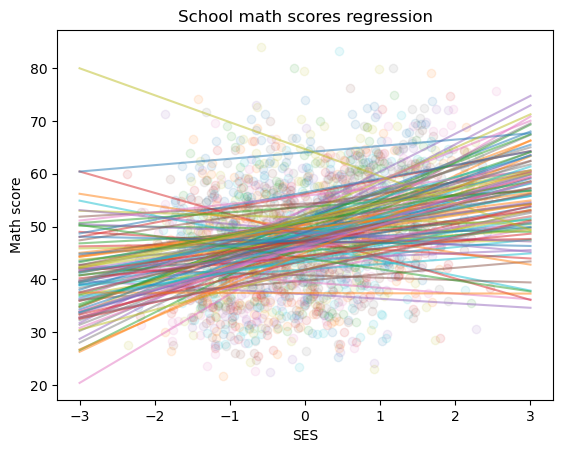

In [13]:
import matplotlib.pyplot as plt
x0 = np.linspace(-3, 3, 10)
# Loop through each school and plot
for i, school_id in enumerate(school_ids):
    # Get the data for this school
    df_school = df[df['sch_id'] == school_id]
    # Get the x and y values
    x = df_school['stu_ses'].values
    y = df_school['stu_mathscore'].values

    # Get the posterior mean of w_j and sigma_square
    w1 = w1_posterior_mean[i]
    w2 = w2_posterior_mean[i]
    sigma_square = sigma_posterior_mean[i]
    # plt.errorbar(x, y, yerr=sigma_square, fmt=".k", capsize=0)
    plt.scatter(x, y,label="data", alpha=0.1)
    plt.plot(x0, w1 + w2*x0,alpha=0.5)
    plt.xlabel("SES")
    plt.ylabel("Math score")

plt.title("School math scores regression")
plt.show()


### Problem 2.2 (3pts):

Now implement the full hierarchical scheme for the school regression coefficient $w_j$ we introduced in the lecture. Use the same hyperprior parameterization you used in 2.1. In other words, the only thing that changes is the linear model now predicts the values for the entire data set. 

Make a corner plot of the posterior for the set of hyperparameters $(\mu, \Sigma, \sigma)$. In another plot, show the linear regression from the mean posterior prediction for every school. Store the posterior means of $w_j$ for every school and of the global $\sigma$ for Problem 2.3.

**Hint:** `numpyro.plate` could be useful. 

In [14]:
from sklearn.preprocessing import LabelEncoder

def model(x,y,school_code=None):
    mu_0_1 = 50
    mu_0_2 = 3
    V_0 = 5
    v_0 = 1
    sigma_0 = 1

    Sigma_1 = numpyro.sample('Sigma_1', dist.InverseGamma(1,2))
    Sigma_2 = numpyro.sample('Sigma_2', dist.InverseGamma(1,2))
    sigma = numpyro.sample('sigma', 
                                  dist.InverseGamma(v_0/2, v_0*sigma_0**2/2))
    mu1 = numpyro.sample('mu1', dist.Normal(mu_0_1, V_0))
    mu2 = numpyro.sample('mu2', dist.Normal(mu_0_2, V_0))

    # Get school ids
    n_schools = len(onp.unique(school_code))
    
    with numpyro.plate("plate_i", n_schools):
        w1 = numpyro.sample('w1', dist.Normal(mu1, Sigma_1))
        w2 = numpyro.sample('w2', dist.Normal(mu2, Sigma_2))
   
    e = numpyro.sample('e',dist.Normal(0, sigma))
    
    y_ = w1[school_code] + w2[school_code] * x

    n_student =  len(school_code)
    with numpyro.plate("data", n_student):
        numpyro.sample("obs", dist.Normal(y_, e), obs=y)

# Get the school code
school_encoder = LabelEncoder()
df["sch_code"] = school_encoder.fit_transform(df["sch_id"].values)
ses_obs = df['stu_ses'].values
mathscore_obs = df["stu_mathscore"].values
school_code = df["sch_code"].values

# need to split the key for jax's random implementation
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Get the x and y values for all schools
x = df['stu_ses'].values
y = df['stu_mathscore'].values

# Fit the model
kernel = NUTS(model, target_accept_prob=0.9)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=3000)
mcmc.run(random.PRNGKey(0), x=ses_obs, y=mathscore_obs, school_code=school_code)
mcmc.print_summary()


sample: 100%|██████████| 4000/4000 [00:17<00:00, 226.92it/s, 31 steps of size 1.85e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Sigma_1      4.01      0.39      3.99      3.38      4.66   2191.48      1.00
   Sigma_2      1.37      0.36      1.37      0.74      1.95    140.62      1.01
         e      8.84      0.15      8.84      8.60      9.09   3036.69      1.00
       mu1     48.00      0.44     48.00     47.27     48.71   3690.81      1.00
       mu2      2.74      0.27      2.74      2.29      3.17   1456.00      1.00
     sigma     19.68     71.13      9.62      2.62     33.42   1708.10      1.00
     w1[0]     51.18      1.50     51.13     48.73     53.60   4515.44      1.00
     w1[1]     46.49      1.69     46.51     43.76     49.31   4599.17      1.00
     w1[2]     49.14      1.67     49.15     46.41     51.88   5762.84      1.00
     w1[3]     47.35      1.78     47.37     44.33     50.16   4728.04      1.00
     w1[4]     39.14      1.80     39.13     36.21     42.03   4560.18      1.00
     w1[5]     41.42      2

In [15]:
# Store the w1 and w2 posterior means, and sigma posterior means
w1_posterior_mean_all = onp.zeros(len(school_ids))
w2_posterior_mean_all = onp.zeros(len(school_ids))

# Loop through each school and get the posterior mean of w1, w2, and sigma
for i, school_id in enumerate(school_ids):
    # Get the posterior mean of w_j
    w1_posterior_mean_all[i] = onp.mean(mcmc.get_samples()['w1'][:,i])
    w2_posterior_mean_all[i] = onp.mean(mcmc.get_samples()['w2'][:,i])
n_schools = len(school_ids)
sigma_posterior_all = onp.array(mcmc.get_samples()['sigma'])[:n_schools]


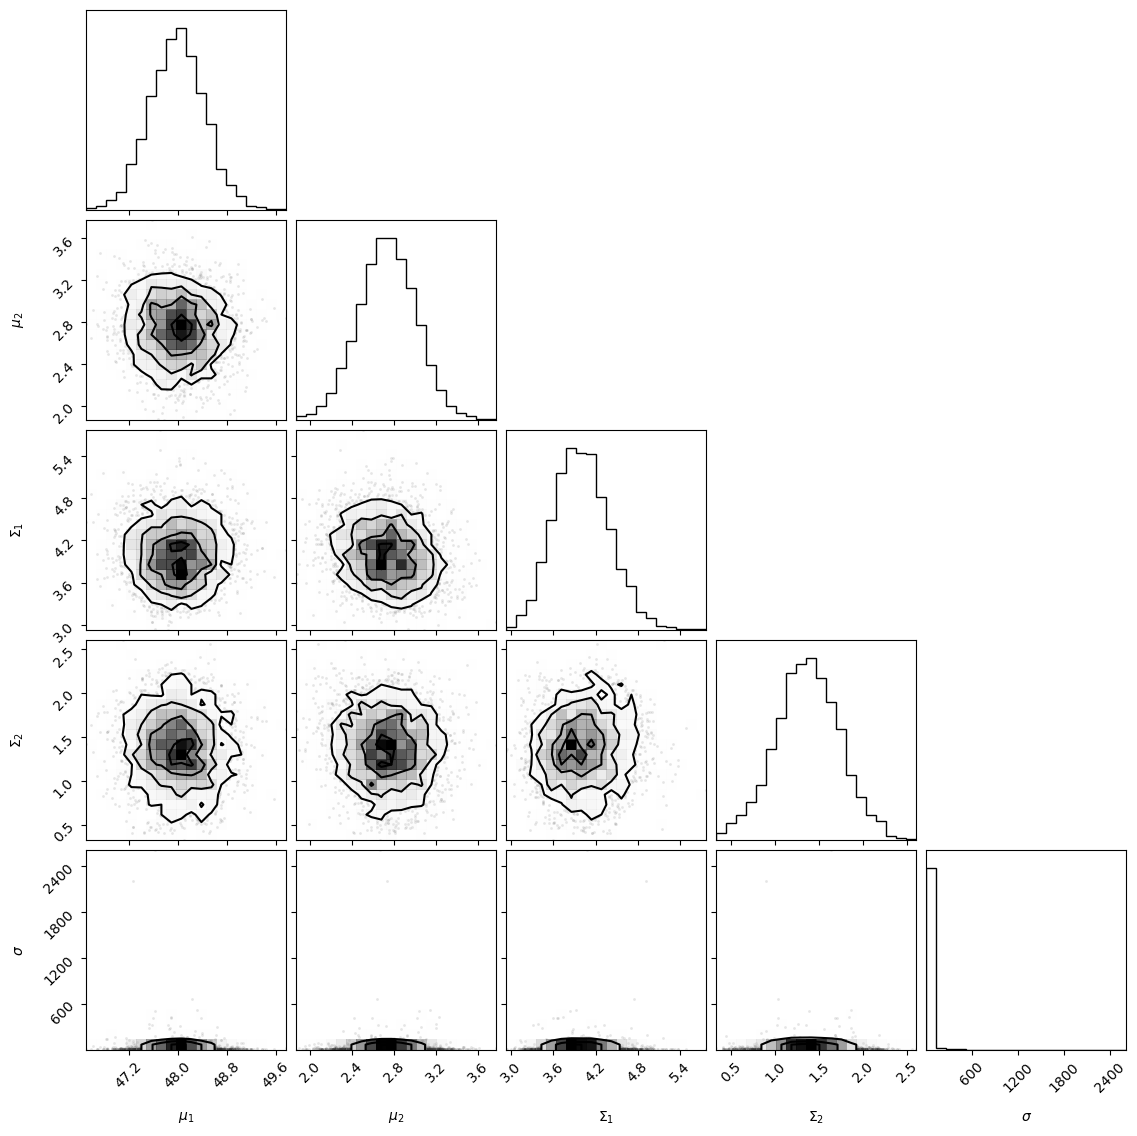

In [16]:
import corner
# Plot the posterior of the hyperparameters using corner
samples = mcmc.get_samples()
mu1 = onp.array(samples['mu1'])
mu2 = onp.array(samples['mu2'])
Sigma_1 = onp.array(samples['Sigma_1'])
Sigma_2 = onp.array(samples['Sigma_2'])
sigma = onp.array(samples['sigma'])

# Create labels for the hyperparameters
labels = [r"$\mu_1$", r"$\mu_2$", r"$\Sigma_1$", r"$\Sigma_2$", r"$\sigma$"]
# Make corner plot for the hyperparameters with labels
fig = corner.corner(onp.vstack([mu1, mu2, Sigma_1, Sigma_2, sigma]).T, labels=labels)


### Problem 2.3 (1pt):

Make a [quiver plot](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.quiver.html) with the coordinates $(w_{j,0}, \sigma_j)$ from 2.1 as starting points and $(w_{j,0},\sigma)$ from 2.2 as end points (one arrow per school). Do the same with $w_{j,1}$ instead of $w_{j,0}$. Color-code each arrow with the number of students in each school. Interpret the result. 

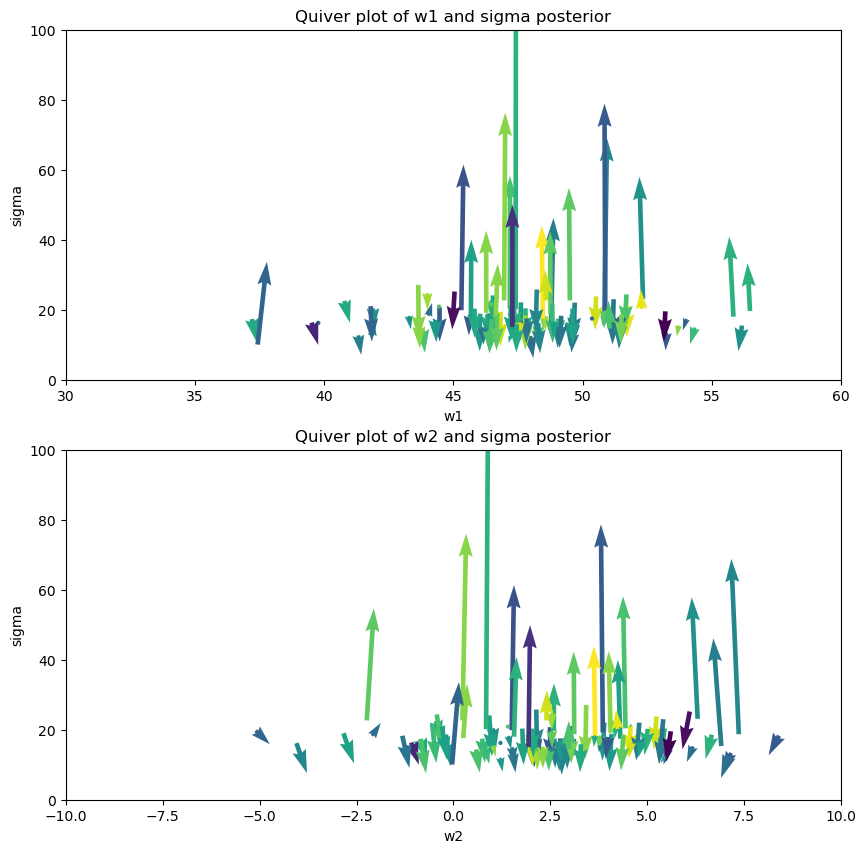

In [22]:
# Make a quiver plot with coordinates (w1_posterior_mean, sigma_square_posterior_mean) and end points (w1_posterior_mean_all, sigma_posterior). Color code with number of students in each school

# Convert to numpy arrays
w1_posterior_mean = onp.array(w1_posterior_mean)
sigma_posterior_mean = onp.array(sigma_posterior_mean)

# Get the number of students in each school
n_students = onp.array([len(df[df['sch_id'] == school_id]) for school_id in school_ids])

# Plot the quiver plot for w1
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].quiver(w1_posterior_mean, sigma_posterior_mean, w1_posterior_mean_all - w1_posterior_mean, sigma_posterior_all - sigma_posterior_mean, n_students)
ax[0].set_xlim(30, 60)
ax[0].set_ylim(0, 100)
ax[0].set_xlabel("w1")
ax[0].set_ylabel("sigma")
ax[0].set_title("Quiver plot of w1 and sigma posterior")

# Plot the quiver plot for w2
ax[1].quiver(w2_posterior_mean, sigma_posterior_mean, w2_posterior_mean_all - w2_posterior_mean, sigma_posterior_all - sigma_posterior_mean, n_students)
ax[1].set_xlim(-10, 10)
ax[1].set_ylim(0, 100)
ax[1].set_xlabel("w2")
ax[1].set_ylabel("sigma")
ax[1].set_title("Quiver plot of w2 and sigma posterior")
plt.show()